
DELAY-TOLERANT FEDERATED LEARNING (DTFL) AT ALPHA(0.15)

--- Round 1/30 ---
Selected clients: [0, 1, 2]
  Client 0: trained (full, 5 epochs)
    → Direct transmission
  Client 1: trained (full, 5 epochs)
    → Direct transmission
  Client 2: trained (full, 5 epochs)
    → Direct transmission
  Warmup phase: server LR = 0.12 * 0.9 = 0.108
   Aggregated 3 updates (server LR: 0.108)

[Round 1 Validation] Accuracy: 30.65%, F1: 0.2886
  New best model! Validation accuracy: 30.65%

--- Round 2/30 ---
Selected clients: [3]
  Client 3: trained (full, 5 epochs)
    → Direct transmission
  Warmup phase: server LR = 0.12 * 0.9 = 0.108
   Aggregated 1 updates (server LR: 0.108)

[Round 2 Validation] Accuracy: 49.91%, F1: 0.4509
  New best model! Validation accuracy: 49.91%

--- Round 3/30 ---
Selected clients: [0, 1]
  Client 0: trained (full, 5 epochs)
    → Direct transmission
  Client 1: trained (full, 5 epochs)
    → Direct transmission
  Warmup phase: server LR = 0.12 * 0.9 = 0.108
   Aggreg

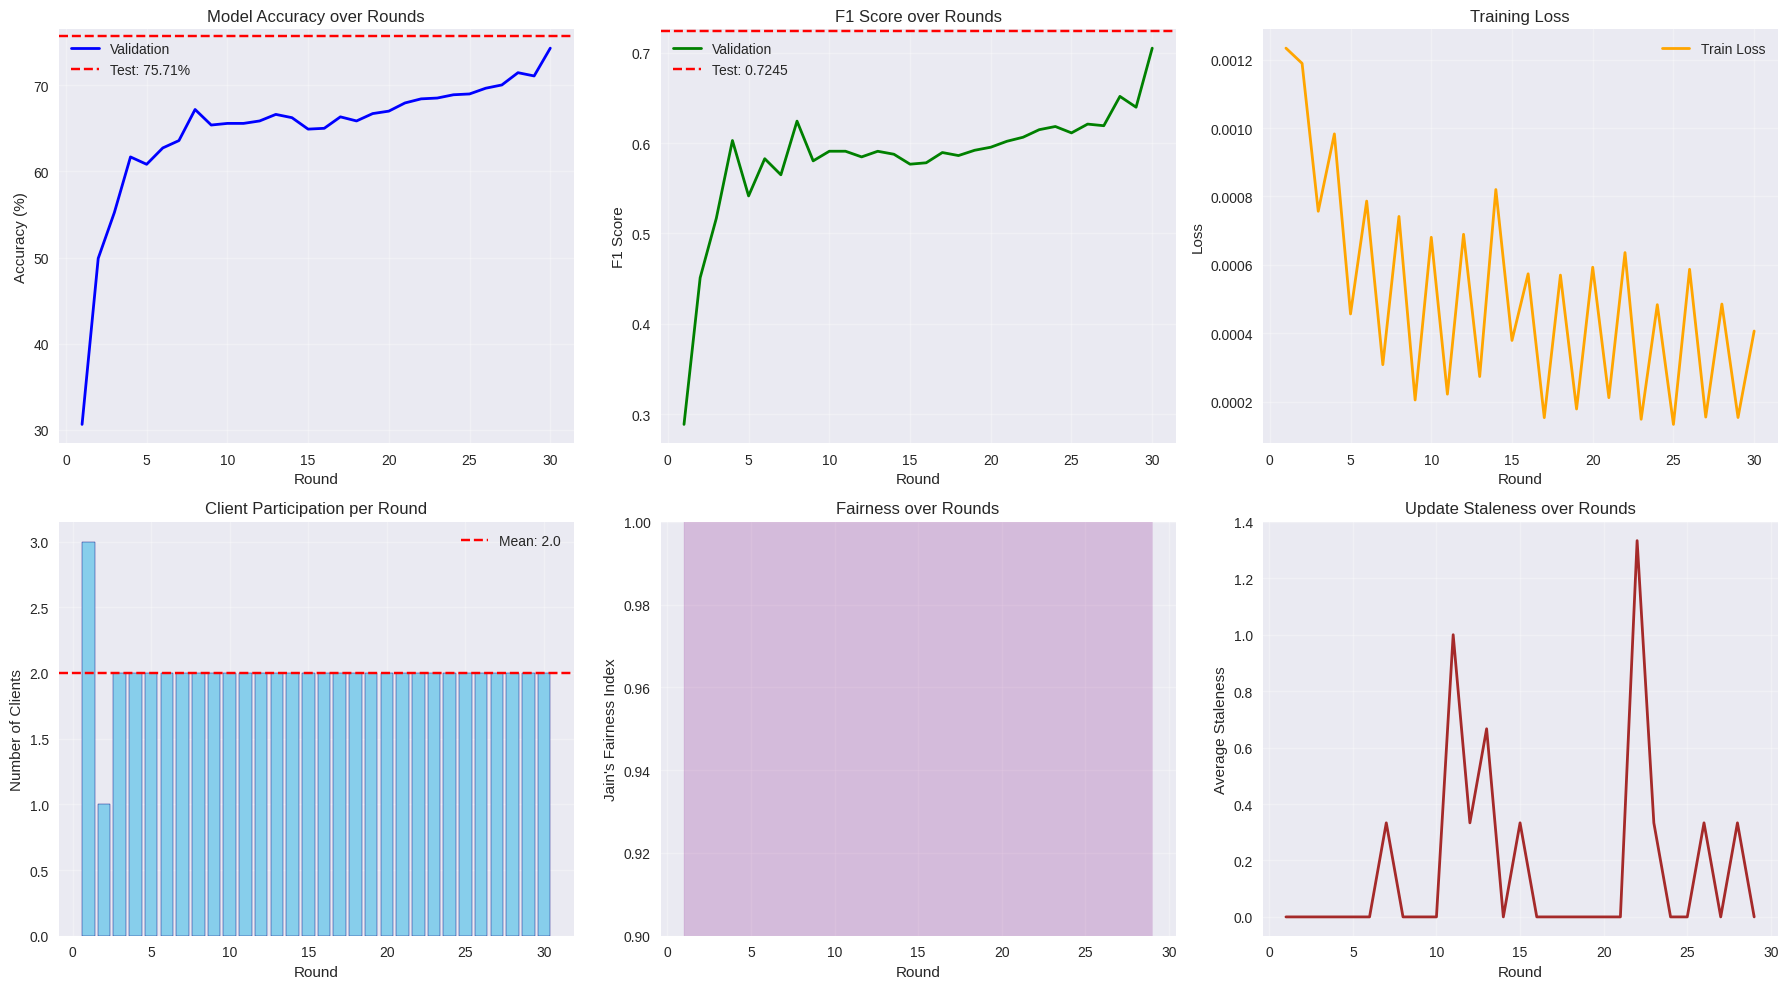

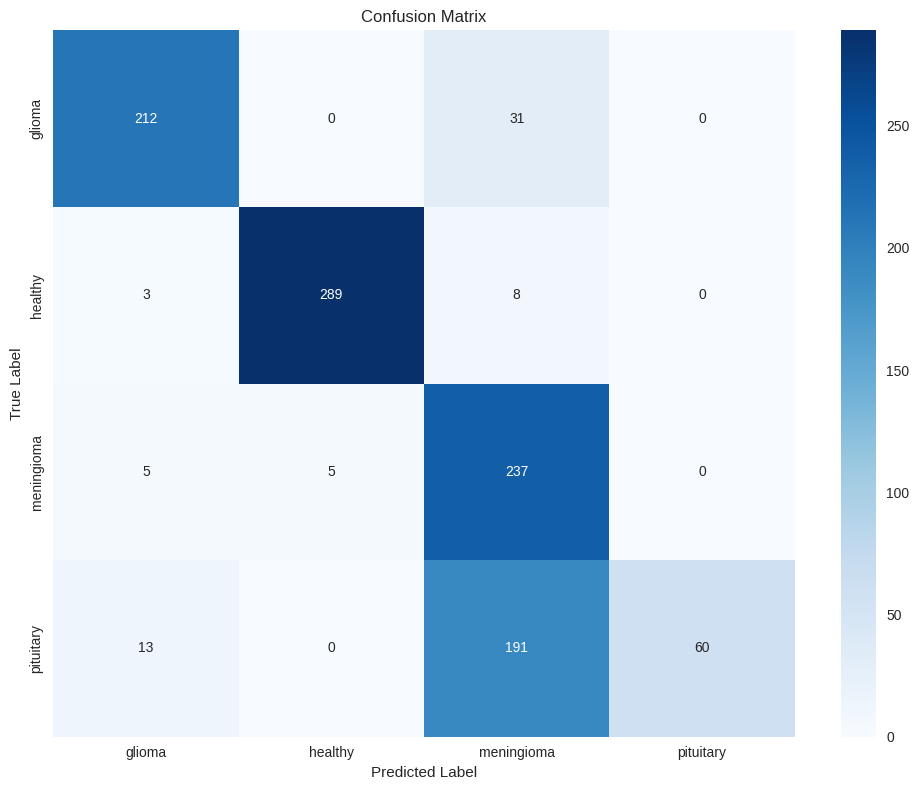

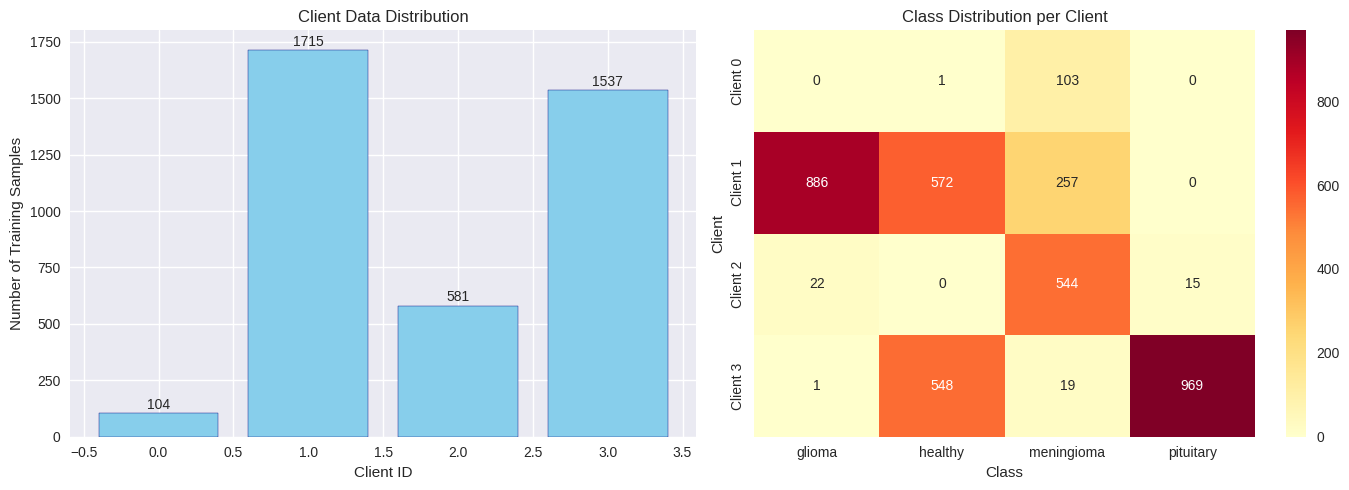

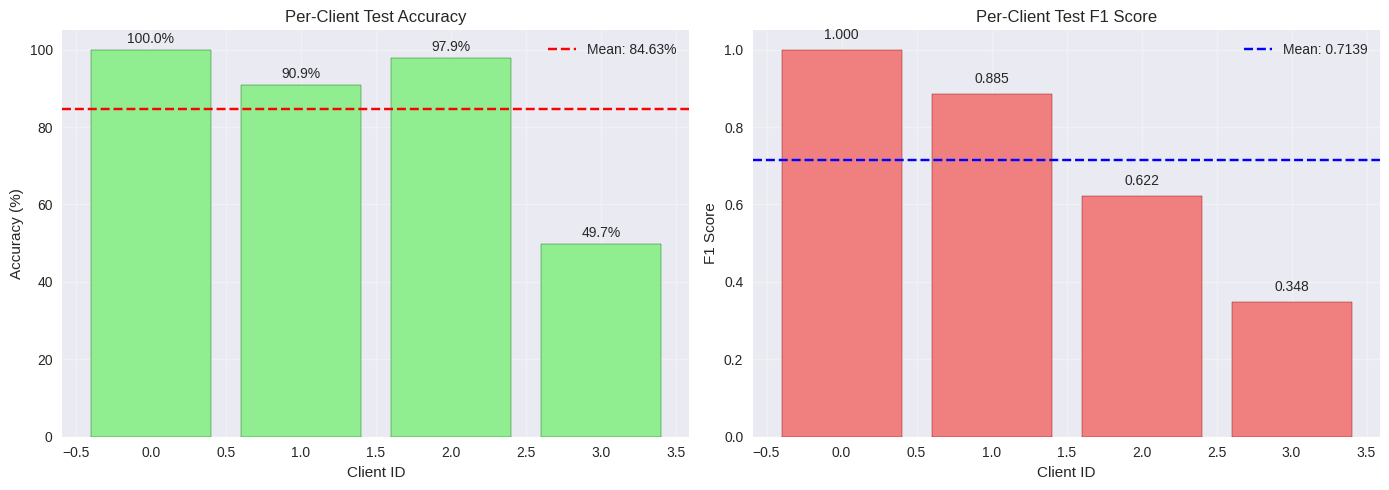

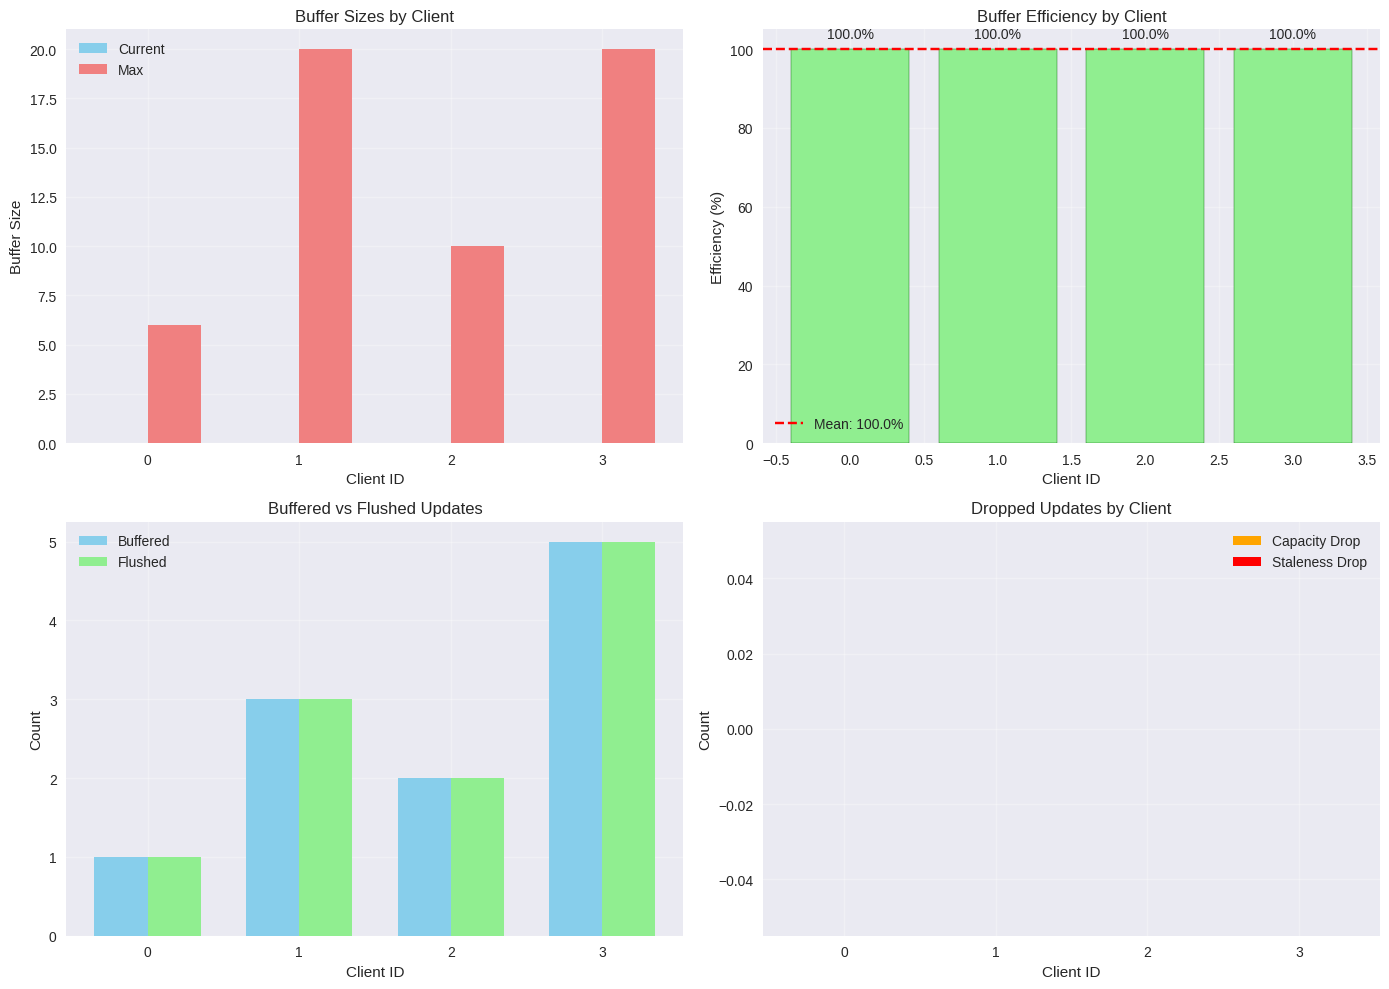

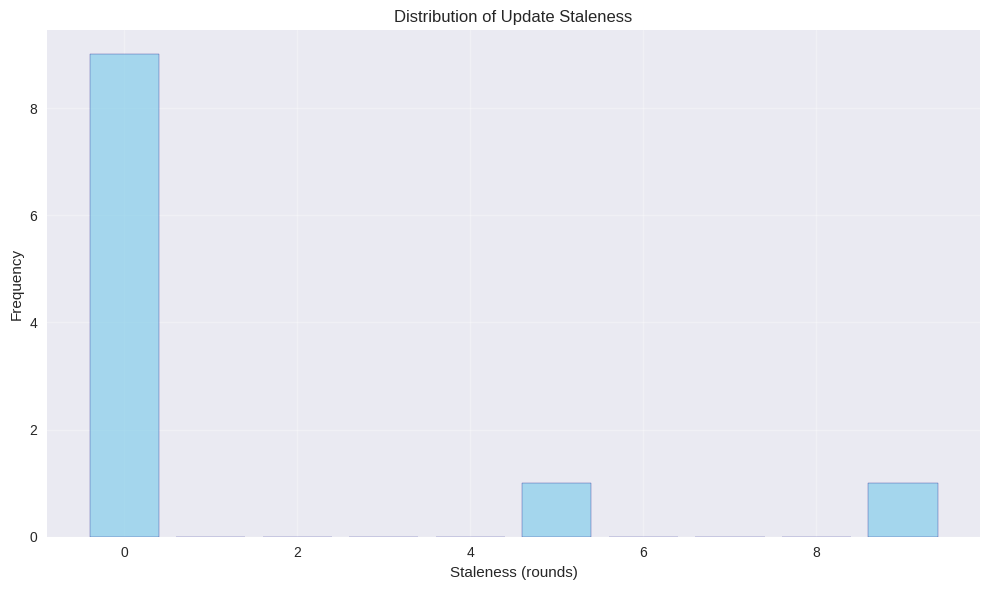

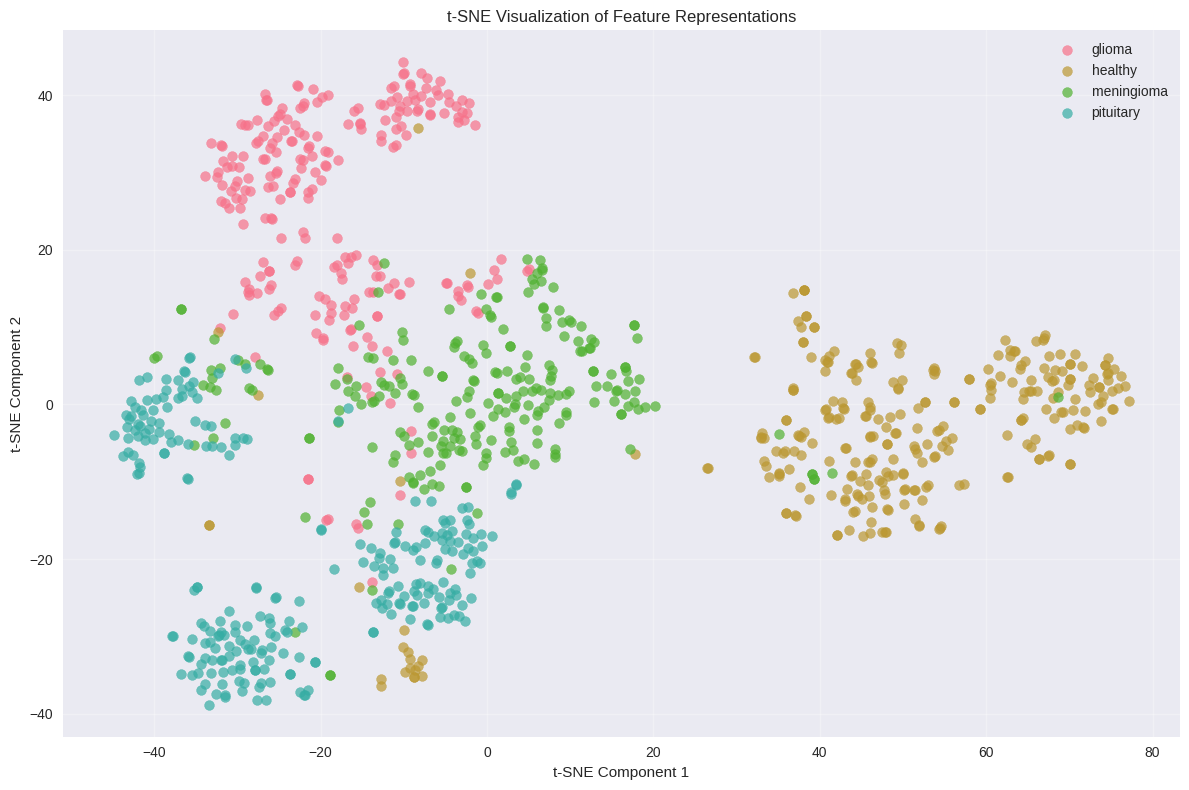

Visualizations saved to: ./dtfl_plots_optimized

DTFL EXPERIMENT SUMMARY

Configuration:
  Clients: 4
  Rounds: 30
  Non-IID Dirichlet Alpha: 0.15

Buffer Statistics:
  Total buffered: 11
  Total flushed: 11
  Buffer efficiency: 100.0%
  Dropped (capacity): 0
  Dropped (staleness): 0

Training Statistics:
  Active clients: 4/4
  Partial updates: 0
  Discarded updates: 0

Validation Performance:
  Best accuracy: 74.29%
  Best F1: 0.7052
  Final accuracy: 74.29%

Test Performance:
  Accuracy: 75.71%
  F1 Score: 0.7245
  Precision: 0.8501
  Recall: 0.7556

Client Fairness:
  Mean client accuracy: 84.63%
  Std client accuracy: 20.43%
  Jain's fairness (accuracy): 0.9450

Visualizations:
  Plots saved to: ./dtfl_plots_optimized
  HTML report: ./dtfl_plots_optimized/report.html

Log file: ./dtfl_logs_optimized/dtfl_run_20260217_122343.json


In [2]:
# %% [markdown]
# # DELAY-TOLERANT FEDERATED LEARNING (DTFL)
# ## Mathematical Framework for Asynchronous Federated Learning

# %%
import os
import sys
import random
import math
import time
import heapq
import numpy as np
from collections import defaultdict, deque
from dataclasses import dataclass, field, asdict
import json
from datetime import datetime
from typing import List, Dict, Tuple, Optional, Any, Union, Callable
import warnings
import pickle
import traceback
import gc
from copy import deepcopy
from pathlib import Path
import logging

from scipy import stats

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torch.nn.utils import clip_grad_norm_
from torch.utils.checkpoint import checkpoint

from torchvision import transforms, models
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd

# Suppress tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

# Suppress torch download messages
import torch.hub
original_download = torch.hub.download_url_to_file

def silent_download(url, dest, *args, **kwargs):
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            original_download(url, dest, *args, **kwargs)
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

torch.hub.download_url_to_file = silent_download

# ============================================================================
# SECTION 1: CONFIGURATION
# ============================================================================

@dataclass
class DTFLConfig:
    """
    Configuration class for Delay-Tolerant Federated Learning.
    
    Mathematical Foundation:
    The system operates under the principle of asynchronous aggregation where
    client updates may arrive with varying delays. The server maintains a global
    model w_t that is updated according to:
    
        w_{t+1} = w_t - η_t * Σ_i (n_i / N) * ∇L_i(w_t, τ_i)
    
    where τ_i represents the staleness of client i's update, and ∇L_i is weighted
    by an exponential decay factor exp(-λ * τ_i).
    """
    
    # Reproducibility
    seed: int = 42
    experiment_name: str = field(default_factory=lambda: f"dtfl_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    
    # Dataset
    dataset_path: str = "/kaggle/input/datasets/rm1000/brain-tumor-mri-scans"
    num_classes: int = 4
    class_names: List[str] = field(default_factory=lambda: ["glioma", "healthy", "meningioma", "pituitary"])
    img_size: int = 224
    
    # Federated setup
    num_clients: int = 4
    clients_per_round: float = 0.75
    min_clients_per_round: int = 2
    total_rounds: int = 30
    
    # Non-IID configuration
    dirichlet_alpha: float = 0.15
    min_samples_per_client: int = 50
    client_test_split: float = 0.2
    
    # Model architecture
    model_architecture: str = "efficientnet_b0"
    pretrained: bool = True
    dropout_rate: float = 0.3
    
    # Learning rates
    features_lr: float = 1e-5
    classifier_lr: float = 1e-4
    weight_decay: float = 1e-4
    momentum: float = 0.9
    server_lr: float = 0.1
    
    # Learning rate scheduling
    lr_schedule: str = "cosine"
    lr_warmup_rounds: int = 10
    lr_min_factor: float = 0.01
    
    # Gradual unfreezing
    unfreeze_start_round: int = 10
    unfreeze_increment: int = 3
    lr_ramp_rounds: int = 10
    
    # FedProx
    """
    FedProx Mathematical Formulation:
    
    The proximal term adds a penalty for deviating from the global model:
    
        L_prox(w) = L(w) + (μ/2) * ||w - w_global||²
    
    The optimal μ is derived from the gradient statistics:
    
        μ* = (2αL) / ||Δw||² * (1 + σ²_g / ||g||²)
    
    where α is the target proximal ratio, L is the loss, Δw is the parameter
    difference, σ²_g is gradient variance, and ||g||² is the mean squared
    gradient norm.
    """
    fedprox_target_ratio: float = 0.05
    fedprox_min_mu: float = 1e-8
    fedprox_max_mu: float = 1.0
    fedprox_ema_beta: float = 0.7
    fedprox_adaptation: str = "variance"
    
    # Gradient clipping
    enable_gradient_clipping: bool = True
    gradient_clip_norm: float = 1.0
    max_update_norm: float = 10.0
    
    # Server aggregation
    server_aggregation_factor: float = 1.0
    server_aggregation_min: float = 0.05
    warmup_rounds: int = 5
    
    # Staleness handling
    """
    Staleness Weighting:
    
    Updates are weighted by an exponential decay factor based on their staleness τ:
    
        w(τ) = exp(-λ * τ)
    
    where λ is the staleness decay rate. This ensures that fresher updates
    contribute more to the global model.
    """
    enable_staleness: bool = True
    staleness_decay: float = 0.7
    staleness_max_rounds: int = 5
    staleness_lambda: float = 0.3
    
    # Fairness weighting
    """
    Fairness Formulation:
    
    Jain's fairness index measures the equality of contributions:
    
        J(x) = (Σ x_i)² / (n * Σ x_i²)
    
    The fairness modifier for client i is:
    
        m_i = 1 + α * (1 - c_i / max(c))
    
    where c_i is the effective contribution of client i, and α controls the
    strength of the fairness adjustment.
    """
    enable_fairness: bool = True
    fairness_temperature: float = 1.0
    fairness_alpha: float = 0.2
    fairness_ema: float = 0.95
    
    # DTFL Buffer
    """
    Buffer Priority Scoring:
    
    Updates in the buffer are prioritized by:
    
        P = S_τ^α * S_p^(1-α) * S_n^0.5
    
    where S_τ is staleness score (exponential decay), S_p is performance score
    (inverse loss normalized), and S_n is update norm score.
    """
    enable_buffering: bool = True
    buffer_max_size: int = 20
    buffer_max_age: int = 5
    buffer_flush_per_round: int = 2
    buffer_priority_alpha: float = 0.5
    max_staleness_rounds: int = 10
    emergency_flush_threshold: int = 3
    emergency_max_age: int = 5
    
    # Availability sampling
    enable_adaptive_sampling: bool = True
    base_availability_prob: float = 0.75
    availability_pattern: str = "realistic"
    availability_model: str = "bernoulli"
    client_availability_prob: float = 0.75
    
    # Local training
    batch_size: int = 16
    local_epochs: int = 5
    local_validation_split: float = 0.2
    local_early_stopping_patience: int = 3
    local_early_stopping_metric: str = "loss"
    
    # Class imbalance
    use_focal_loss: bool = True
    focal_gamma: float = 2.0
    
    # Client cooldown
    enable_client_cooldown: bool = True
    client_cooldown_rounds: int = 2
    
    # Straggler mitigation
    enable_straggler_handling: bool = True
    straggler_timeout_seconds: float = 120.0
    min_epochs_for_partial: int = 3
    partial_update_ratio: float = 0.3
    
    # Client dropout recovery
    enable_dropout_recovery: bool = True
    max_consecutive_dropouts: int = 3
    recovery_model_version: str = "latest"
    
    # Feature distillation
    """
    Feature Distillation Loss:
    
    The distillation loss preserves feature representations from previous stages:
    
        L_distill = β * MSE(f_current(x), f_frozen(x))
    
    where β is adaptively weighted based on feature similarity:
    
        β = β_base * (1 - sim_ema)
    
    and sim_ema is the exponential moving average of cosine similarity between
    current and frozen features.
    """
    enable_feature_distillation: bool = True
    distillation_weight: float = 0.1
    distillation_temperature: float = 2.0
    distillation_adaptation: bool = True
    distillation_similarity_ema_beta: float = 0.9
    
    # Differential privacy
    enable_differential_privacy: bool = False
    dp_noise_multiplier: float = 1.0
    dp_clip_norm: float = 1.0
    dp_delta: float = 1e-5
    dp_max_per_sample_grad_norm: float = 1.0
    
    # Gradient flow monitoring
    gradient_flow_threshold: float = 1e-4
    dead_neuron_threshold: float = 1e-6
    
    # Batch norm handling
    track_bn_stats: bool = True
    sync_bn_before_unfreeze: bool = True
    
    # Feature unfreezing
    feature_blocks: int = 7
    unfreeze_blocks_per_round: int = 1
    
    # Validation
    validate_every_batch: bool = False
    checkpoint_frequency: int = 10
    eval_every: int = 1
    
    # Data leakage prevention
    patient_id_patterns: List[str] = field(default_factory=lambda: [
        r'patient[_-]?(\d+)',
        r'pat[_-]?(\d+)', 
        r'case[_-]?(\d+)',
        r'subject[_-]?(\d+)',
        r'id[_-]?(\d+)',
        r'(\d{3,})'
    ])
    
    # Early stopping
    early_stopping_patience: int = 15
    early_stopping_metric: str = "accuracy"
    enable_early_stopping: bool = True
    
    # Client failure handling
    max_client_retries: int = 3
    client_retry_delay: float = 1.0
    
    # Gradient checkpointing
    enable_gradient_checkpointing: bool = False
    gradient_checkpointing_segments: int = 4
    
    # DataLoader settings
    num_workers: int = 0
    pin_memory: bool = False
    prefetch_factor: int = 2
    
    # Validation splits
    validation_split: float = 0.15
    test_split: float = 0.15
    test_eval_frequency: int = 20
    
    # Runtime
    max_runtime_hours: float = 8.0
    ablation_mode: str = "full"
    adaptive_lr_decay: bool = True
    lr_decay_rounds: int = 10
    lr_decay_factor: float = 0.95
    
    # Visualization
    create_plots: bool = True
    plot_style: str = "seaborn-v0_8"
    fig_size: Tuple[int, int] = (12, 8)
    dpi: int = 100
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Logging
    log_dir: str = "./dtfl_logs"
    plot_dir: str = "./dtfl_plots"
    save_plots: bool = True
    verbose: bool = False
    
    def __post_init__(self):
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.plot_dir, exist_ok=True)
        self.experiment_path = os.path.join(self.log_dir, self.experiment_name)
        os.makedirs(self.experiment_path, exist_ok=True)
        self.plots_dir = os.path.join(self.experiment_path, "plots")
        os.makedirs(self.plots_dir, exist_ok=True)
        
        # Validate configuration parameters
        assert 0 < self.fedprox_target_ratio < 1, "fedprox_target_ratio must be in (0,1)"
        assert self.fedprox_min_mu < self.fedprox_max_mu, "fedprox_min_mu must be less than fedprox_max_mu"
        assert 0 < self.server_aggregation_min <= 1, "server_aggregation_min must be in (0, 1]"
        assert self.gradient_clip_norm > 0, "gradient_clip_norm must be positive"
        assert 0 < self.staleness_decay <= 1, "staleness_decay must be in (0,1]"
        assert self.staleness_max_rounds >= 1, "staleness_max_rounds must be >= 1"
        assert 0 < self.local_validation_split < 1, "local_validation_split must be in (0,1)"
        
        if self.model_architecture == "efficientnet_b0":
            assert self.feature_blocks == 7, f"EfficientNet-B0 has 7 blocks, got {self.feature_blocks}"
        
        assert self.classifier_lr >= 5 * self.features_lr, "classifier_lr should be at least 5x features_lr"
        assert self.buffer_flush_per_round <= self.buffer_max_size, \
            f"flush_per_round ({self.buffer_flush_per_round}) cannot exceed buffer_max_size ({self.buffer_max_size})"
        assert 0 <= self.buffer_priority_alpha <= 1, "buffer_priority_alpha must be in [0,1]"
        assert self.unfreeze_start_round < self.total_rounds, "unfreeze_start_round must be before total_rounds"
        assert self.unfreeze_increment > 0, "unfreeze_increment must be positive"
        assert 0 < self.clients_per_round <= 1, "clients_per_round must be in (0, 1]"
        assert self.min_clients_per_round <= self.num_clients, "min_clients_per_round cannot exceed num_clients"
        
        if self.enable_differential_privacy:
            assert self.dp_noise_multiplier > 0, "dp_noise_multiplier must be positive"
            assert self.dp_clip_norm > 0, "dp_clip_norm must be positive"
            assert self.dp_max_per_sample_grad_norm > 0, "dp_max_per_sample_grad_norm must be positive"
        
        assert self.max_client_retries >= 0, "max_client_retries must be non-negative"
        assert self.client_retry_delay >= 0, "client_retry_delay must be non-negative"


def config_to_dict(config: DTFLConfig) -> Dict:
    """Convert configuration to JSON-serializable dictionary."""
    config_dict = asdict(config)
    config_dict.pop('class_names', None)
    config_dict.pop('patient_id_patterns', None)
    return config_dict


# ============================================================================
# SECTION 2: VISUALIZATION UTILITIES
# ============================================================================

class DTFLVisualizer:
    """Visualization tools for DTFL experiments."""
    
    def __init__(self, config):
        self.config = config
        self.plot_dir = config.plot_dir
        os.makedirs(self.plot_dir, exist_ok=True)
        
        plt.style.use(config.plot_style)
        sns.set_palette("husl")
    
    def plot_training_progress(self, history):
        """Plot training metrics over communication rounds."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        rounds = range(1, len(history['val_accuracy']) + 1)
        
        # Accuracy plot
        axes[0, 0].plot(rounds, history['val_accuracy'], 'b-', linewidth=2, label='Validation')
        if history.get('test_accuracy'):
            axes[0, 0].axhline(y=history['test_accuracy'], color='r', linestyle='--', 
                              label=f"Test: {history['test_accuracy']:.2f}%")
        axes[0, 0].set_xlabel('Round')
        axes[0, 0].set_ylabel('Accuracy (%)')
        axes[0, 0].set_title('Model Accuracy over Rounds')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.15)
        
        # F1 Score plot
        axes[0, 1].plot(rounds, history['val_f1'], 'g-', linewidth=2, label='Validation')
        if history.get('test_f1'):
            axes[0, 1].axhline(y=history['test_f1'], color='r', linestyle='--',
                              label=f"Test: {history['test_f1']:.4f}")
        axes[0, 1].set_xlabel('Round')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].set_title('F1 Score over Rounds')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.15)
        
        # Loss plot
        if history.get('train_loss'):
            axes[0, 2].plot(rounds[:len(history['train_loss'])], history['train_loss'], 'orange', linewidth=2, label='Train Loss')
        axes[0, 2].set_xlabel('Round')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].set_title('Training Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.15)
        
        # Participation plot
        participation = history.get('participation', [])
        if participation:
            axes[1, 0].bar(rounds[:len(participation)], participation, color='skyblue', edgecolor='navy')
            axes[1, 0].axhline(y=np.mean(participation), color='red', linestyle='--', 
                              label=f"Mean: {np.mean(participation):.1f}")
        axes[1, 0].set_xlabel('Round')
        axes[1, 0].set_ylabel('Number of Clients')
        axes[1, 0].set_title('Client Participation per Round')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.15)
        
        # Fairness plot
        if history.get('jain_fairness'):
            axes[1, 1].plot(rounds[:len(history['jain_fairness'])], history['jain_fairness'], 
                          'purple', linewidth=2)
            axes[1, 1].fill_between(rounds[:len(history['jain_fairness'])], 
                                   history['jain_fairness'], 1.0, alpha=0.2, color='purple')
        axes[1, 1].set_xlabel('Round')
        axes[1, 1].set_ylabel("Jain's Fairness Index")
        axes[1, 1].set_title('Fairness over Rounds')
        axes[1, 1].set_ylim([0.9, 1.0])
        axes[1, 1].grid(True, alpha=0.15)
        
        # Staleness plot
        if history.get('avg_staleness'):
            axes[1, 2].plot(rounds[:len(history['avg_staleness'])], history['avg_staleness'], 
                          'brown', linewidth=2)
        axes[1, 2].set_xlabel('Round')
        axes[1, 2].set_ylabel('Average Staleness')
        axes[1, 2].set_title('Update Staleness over Rounds')
        axes[1, 2].grid(True, alpha=0.15)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'training_progress.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def plot_confusion_matrix(self, cm, class_names):
        """Plot confusion matrix for classification results."""
        plt.figure(figsize=(10, 8))
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'confusion_matrix.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def plot_client_distribution(self, client_data):
        """Plot client data distribution showing sample counts and class balance."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        client_sizes = [data['train_size'] for data in client_data.values()]
        client_ids = list(client_data.keys())
        
        bars = axes[0].bar(client_ids, client_sizes, color='skyblue', edgecolor='navy')
        axes[0].set_xlabel('Client ID')
        axes[0].set_ylabel('Number of Training Samples')
        axes[0].set_title('Client Data Distribution')
        
        for bar, size in zip(bars, client_sizes):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                       str(size), ha='center', va='bottom')
        
        class_dist = np.array([data['class_distribution'] for data in client_data.values()])
        
        sns.heatmap(class_dist, annot=True, fmt='d', cmap='YlOrRd', 
                   xticklabels=self.config.class_names,
                   yticklabels=[f'Client {i}' for i in client_ids],
                   ax=axes[1])
        axes[1].set_xlabel('Class')
        axes[1].set_ylabel('Client')
        axes[1].set_title('Class Distribution per Client')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'client_distribution.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def plot_client_performance(self, client_accuracies, client_f1_scores):
        """Plot per-client performance metrics."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        client_ids = list(client_accuracies.keys())
        acc_values = list(client_accuracies.values())
        f1_values = list(client_f1_scores.values())
        
        bars1 = axes[0].bar(client_ids, acc_values, color='lightgreen', edgecolor='darkgreen')
        axes[0].axhline(y=np.mean(acc_values), color='red', linestyle='--', 
                       label=f"Mean: {np.mean(acc_values):.2f}%")
        axes[0].set_xlabel('Client ID')
        axes[0].set_ylabel('Accuracy (%)')
        axes[0].set_title('Per-Client Test Accuracy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.15)
        
        for bar, acc in zip(bars1, acc_values):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{acc:.1f}%', ha='center', va='bottom')
        
        bars2 = axes[1].bar(client_ids, f1_values, color='lightcoral', edgecolor='darkred')
        axes[1].axhline(y=np.mean(f1_values), color='blue', linestyle='--',
                       label=f"Mean: {np.mean(f1_values):.4f}")
        axes[1].set_xlabel('Client ID')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_title('Per-Client Test F1 Score')
        axes[1].legend()
        axes[1].grid(True, alpha=0.15)
        
        for bar, f1 in zip(bars2, f1_values):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{f1:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'client_performance.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def plot_buffer_statistics(self, buffer_stats):
        """Plot buffer utilization and efficiency statistics."""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        client_ids = list(buffer_stats.keys())
        
        current_sizes = [stats['current_size'] for stats in buffer_stats.values()]
        max_sizes = [stats['max_size'] for stats in buffer_stats.values()]
        
        x = np.arange(len(client_ids))
        width = 0.35
        
        axes[0, 0].bar(x - width/2, current_sizes, width, label='Current', color='skyblue')
        axes[0, 0].bar(x + width/2, max_sizes, width, label='Max', color='lightcoral')
        axes[0, 0].set_xlabel('Client ID')
        axes[0, 0].set_ylabel('Buffer Size')
        axes[0, 0].set_title('Buffer Sizes by Client')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(client_ids)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.15)
        
        efficiencies = [stats['efficiency'] for stats in buffer_stats.values()]
        
        bars = axes[0, 1].bar(client_ids, efficiencies, color='lightgreen', edgecolor='darkgreen')
        axes[0, 1].axhline(y=np.mean(efficiencies), color='red', linestyle='--',
                          label=f"Mean: {np.mean(efficiencies):.1f}%")
        axes[0, 1].set_xlabel('Client ID')
        axes[0, 1].set_ylabel('Efficiency (%)')
        axes[0, 1].set_title('Buffer Efficiency by Client')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.15)
        
        for bar, eff in zip(bars, efficiencies):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                           f'{eff:.1f}%', ha='center', va='bottom')
        
        total_buffered = [stats['total_buffered'] for stats in buffer_stats.values()]
        total_flushed = [stats['total_flushed'] for stats in buffer_stats.values()]
        
        axes[1, 0].bar(x - width/2, total_buffered, width, label='Buffered', color='skyblue')
        axes[1, 0].bar(x + width/2, total_flushed, width, label='Flushed', color='lightgreen')
        axes[1, 0].set_xlabel('Client ID')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Buffered vs Flushed Updates')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(client_ids)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.15)
        
        total_dropped = [stats['total_dropped'] for stats in buffer_stats.values()]
        total_stale = [stats['total_stale_dropped'] for stats in buffer_stats.values()]
        
        axes[1, 1].bar(x - width/2, total_dropped, width, label='Capacity Drop', color='orange')
        axes[1, 1].bar(x + width/2, total_stale, width, label='Staleness Drop', color='red')
        axes[1, 1].set_xlabel('Client ID')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Dropped Updates by Client')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(client_ids)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.15)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'buffer_statistics.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def plot_staleness_distribution(self, staleness_histogram):
        """Plot distribution of update staleness values."""
        plt.figure(figsize=(10, 6))
        
        bins = range(len(staleness_histogram))
        plt.bar(bins, staleness_histogram, color='skyblue', edgecolor='navy', alpha=0.7)
        
        plt.xlabel('Staleness (rounds)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Update Staleness')
        plt.grid(True, alpha=0.15)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'staleness_distribution.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def create_interactive_dashboard(self, history, client_data, buffer_stats):
        """Create an interactive Plotly dashboard for comprehensive visualization."""
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=('Validation Accuracy', 'F1 Score', 
                          'Client Participation', 'Fairness Index',
                          'Buffer Efficiency', 'Staleness Distribution'),
            specs=[[{'secondary_y': False}, {'secondary_y': False}],
                   [{'secondary_y': False}, {'secondary_y': False}],
                   [{'type': 'bar'}, {'type': 'histogram'}]]
        )
        
        rounds = list(range(1, len(history['val_accuracy']) + 1))
        
        fig.add_trace(
            go.Scatter(x=rounds, y=history['val_accuracy'], mode='lines+markers',
                      name='Validation Accuracy', line=dict(color='blue', width=2)),
            row=1, col=1
        )
        
        if history.get('val_f1'):
            fig.add_trace(
                go.Scatter(x=rounds[:len(history['val_f1'])], y=history['val_f1'], 
                          mode='lines+markers', name='F1 Score', line=dict(color='green', width=2)),
                row=1, col=2
            )
        
        if history.get('participation'):
            fig.add_trace(
                go.Bar(x=rounds[:len(history['participation'])], y=history['participation'],
                      name='Clients per Round', marker_color='skyblue'),
                row=2, col=1
            )
        
        if history.get('jain_fairness'):
            fig.add_trace(
                go.Scatter(x=rounds[:len(history['jain_fairness'])], y=history['jain_fairness'],
                          mode='lines', name="Jain's Fairness", line=dict(color='purple', width=2)),
                row=2, col=2
            )
        
        client_ids = list(buffer_stats.keys())
        efficiencies = [stats['efficiency'] for stats in buffer_stats.values()]
        
        fig.add_trace(
            go.Bar(x=client_ids, y=efficiencies, name='Buffer Efficiency',
                  marker_color='orange', text=[f'{e:.1f}%' for e in efficiencies],
                  textposition='outside'),
            row=3, col=1
        )
        
        if history.get('staleness_histogram'):
            bins = list(range(len(history['staleness_histogram'])))
            fig.add_trace(
                go.Bar(x=bins, y=history['staleness_histogram'], name='Staleness',
                      marker_color='coral'),
                row=3, col=2
            )
        
        fig.update_layout(height=1200, showlegend=True, 
                         title_text="DTFL Interactive Dashboard")
        fig.update_xaxes(title_text="Round", row=1, col=1)
        fig.update_xaxes(title_text="Round", row=1, col=2)
        fig.update_xaxes(title_text="Round", row=2, col=1)
        fig.update_xaxes(title_text="Round", row=2, col=2)
        fig.update_xaxes(title_text="Client ID", row=3, col=1)
        fig.update_xaxes(title_text="Staleness (rounds)", row=3, col=2)
        
        fig.update_yaxes(title_text="Accuracy (%)", row=1, col=1)
        fig.update_yaxes(title_text="F1 Score", row=1, col=2)
        fig.update_yaxes(title_text="Number of Clients", row=2, col=1)
        fig.update_yaxes(title_text="Fairness Index", row=2, col=2, range=[0.9, 1.0])
        fig.update_yaxes(title_text="Efficiency (%)", row=3, col=1)
        fig.update_yaxes(title_text="Frequency", row=3, col=2)
        
        fig.write_html(os.path.join(self.plot_dir, 'interactive_dashboard.html'))
        fig.show()
    
    def plot_tsne_visualization(self, model, dataset, device):
        """t-SNE visualization of feature representations from the model."""
        model.eval()
        features = []
        labels = []
        
        loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
        
        def hook_fn(module, input, output):
            features.append(output.detach().cpu().numpy())
        
        for name, module in model.named_modules():
            if 'classifier' in name and len(list(module.children())) > 0:
                if isinstance(module[0], nn.Dropout):
                    handle = module[0].register_forward_hook(hook_fn)
                    break
        
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                _ = model(x)
                labels.extend(y.numpy())
        
        if 'handle' in locals():
            handle.remove()
        
        if not features:
            return
            
        features = np.concatenate(features, axis=0)
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
        features_2d = tsne.fit_transform(features)
        
        plt.figure(figsize=(12, 8))
        
        for i, class_name in enumerate(self.config.class_names):
            mask = np.array(labels) == i
            if np.any(mask):
                plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                           label=class_name, alpha=0.7, s=50)
        
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.title('t-SNE Visualization of Feature Representations')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.plot_dir, 'tsne_visualization.png'), dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
    
    def generate_report(self, history, client_metrics, buffer_stats, config):
        """Generate comprehensive HTML report with all experiment results."""
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>DTFL Experiment Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; }}
                h1 {{ color: #2c3e50; }}
                h2 {{ color: #34495e; }}
                table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
                th {{ background-color: #3498db; color: white; }}
                tr:nth-child(even) {{ background-color: #f2f2f2; }}
                .metric {{ font-size: 24px; font-weight: bold; color: #27ae60; }}
                .plot-container {{ margin: 30px 0; text-align: center; }}
                img {{ max-width: 100%; height: auto; box-shadow: 0 4px 8px rgba(0,0,0,0.1); }}
            </style>
        </head>
        <body>
            <h1>Delay-Tolerant Federated Learning (DTFL) Experiment Report</h1>
            <p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            
            <h2>Configuration</h2>
            <table>
                <tr><th>Parameter</th><th>Value</th></tr>
                <tr><td>Number of Clients</td><td>{config.num_clients}</td></tr>
                <tr><td>Total Rounds</td><td>{config.total_rounds}</td></tr>
                <tr><td>Non-IID Alpha</td><td>{config.dirichlet_alpha}</td></tr>
                <tr><td>Ablation Mode</td><td>{config.ablation_mode}</td></tr>
                <tr><td>Staleness Lambda</td><td>{config.staleness_lambda}</td></tr>
                <tr><td>Fairness Alpha</td><td>{config.fairness_alpha}</td></tr>
            </table>
            
            <h2>Final Performance Metrics</h2>
            <table>
                <tr><th>Metric</th><th>Value</th></tr>
                <tr><td>Best Validation Accuracy</td><td class="metric">{history.get('best_val_acc', 0):.2f}%</td></tr>
                <tr><td>Test Accuracy</td><td class="metric">{history.get('test_accuracy', 0):.2f}%</td></tr>
                <tr><td>Test F1 Score</td><td class="metric">{history.get('test_f1', 0):.4f}</td></tr>
                <tr><td>Test Precision</td><td class="metric">{history.get('test_precision', 0):.4f}</td></tr>
                <tr><td>Test Recall</td><td class="metric">{history.get('test_recall', 0):.4f}</td></tr>
                <tr><td>Jain's Fairness Index</td><td class="metric">{history.get('jain_fairness', [0])[-1] if history.get('jain_fairness') else 0:.4f}</td></tr>
            </table>
            
            <h2>Client Performance</h2>
            <table>
                <tr><th>Client ID</th><th>Accuracy (%)</th><th>F1 Score</th></tr>
                {''.join([f'<tr><td>{cid}</td><td>{acc:.2f}%</td><td>{client_metrics["f1"].get(cid, 0):.4f}</td></tr>' 
                         for cid, acc in client_metrics['accuracy'].items()])}
            </table>
            
            <h2>Buffer Statistics</h2>
            <table>
                <tr><th>Client</th><th>Current Size</th><th>Max Size</th><th>Efficiency</th><th>Buffered</th><th>Flushed</th></tr>
                {''.join([f'<tr><td>{cid}</td><td>{stats["current_size"]}</td><td>{stats["max_size"]}</td>'
                         f'<td>{stats["efficiency"]:.1f}%</td><td>{stats["total_buffered"]}</td>'
                         f'<td>{stats["total_flushed"]}</td></tr>' 
                         for cid, stats in buffer_stats.items()])}
            </table>
            
            <h2>Visualizations</h2>
            <div class="plot-container">
                <img src="training_progress.png" alt="Training Progress">
            </div>
            <div class="plot-container">
                <img src="client_performance.png" alt="Client Performance">
            </div>
            <div class="plot-container">
                <img src="confusion_matrix.png" alt="Confusion Matrix">
            </div>
            <div class="plot-container">
                <img src="client_distribution.png" alt="Client Distribution">
            </div>
            
            <p>For interactive visualizations, open <a href="interactive_dashboard.html">interactive_dashboard.html</a></p>
        </body>
        </html>
        """
        
        with open(os.path.join(self.plot_dir, 'report.html'), 'w') as f:
            f.write(html_content)


# ============================================================================
# SECTION 3: FOCAL LOSS
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    
    Mathematical Formulation:
        FL(p_t) = -α_t (1 - p_t)^γ log(p_t)
    
    where p_t is the model's estimated probability for the true class,
    γ is the focusing parameter, and α_t is a class balancing weight.
    """
    
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')
    
    def forward(self, input, target):
        ce_loss = self.ce(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                alpha_t = self.alpha[target].to(input.device)
            else:
                alpha_t = torch.tensor([self.alpha[t] for t in target]).to(input.device)
            focal_loss = alpha_t * focal_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# ============================================================================
# SECTION 4: FAIRNESS TRACKER
# ============================================================================

class FairnessTracker:
    """
    Tracks client contributions and computes fairness metrics.
    
    Jain's Fairness Index:
        J(x) = (Σ_i x_i)² / (n * Σ_i x_i²)
    
    where x_i represents the effective contribution of client i, and n is the
    number of clients. The index ranges from 1/n (worst) to 1 (best).
    """
    
    def __init__(self, num_clients, config):
        self.config = config
        self.effective_contribution = np.ones(num_clients)
        self.participation_count = np.zeros(num_clients)
        self.last_update_round = np.zeros(num_clients)
        self.contribution_history = deque(maxlen=50)
        self.update_magnitude_history = defaultdict(list)
    
    def update(self, client_id, samples, staleness, update_magnitude, round_num):
        decay = math.exp(-self.config.staleness_lambda * staleness) if staleness > 0 and self.config.enable_staleness else 1.0
        
        sample_contribution = samples * decay
        
        if update_magnitude > 0:
            magnitude_factor = 1.0 / (1.0 + math.log1p(update_magnitude))
        else:
            magnitude_factor = 1.0
        
        combined_contribution = sample_contribution * magnitude_factor
        
        self.effective_contribution[client_id] = (
            self.config.fairness_ema * self.effective_contribution[client_id] + 
            (1 - self.config.fairness_ema) * combined_contribution
        )
        
        self.participation_count[client_id] += 1
        self.last_update_round[client_id] = round_num
        self.update_magnitude_history[client_id].append(update_magnitude)
        self.contribution_history.append(self.effective_contribution.copy())
    
    def get_fairness_modifiers(self):
        inv_contribution = 1.0 / (self.effective_contribution + 1e-6)
        normalized = inv_contribution / inv_contribution.max()
        modifiers = 1 + self.config.fairness_alpha * (1 - normalized)
        return modifiers
    
    def get_jain_fairness_index(self):
        x = self.effective_contribution
        if np.sum(x) == 0:
            return 1.0
        jain = (np.sum(x) ** 2) / (len(x) * np.sum(x ** 2) + 1e-8)
        return jain
    
    def get_stats(self):
        return {
            "effective_contribution": self.effective_contribution.tolist(),
            "participation_count": self.participation_count.tolist(),
            "jain_fairness_index": self.get_jain_fairness_index(),
            "avg_update_magnitude": {k: np.mean(v) for k, v in self.update_magnitude_history.items()}
        }


# ============================================================================
# SECTION 5: DATASET
# ============================================================================

class BrainTumorDataset(Dataset):
    """Brain tumor MRI dataset with rigorous validation."""
    
    def __init__(self, root: str, config: DTFLConfig):
        self.root = root
        self.config = config
        self.samples = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(config.class_names)}
        self.patient_ids = []
        self.class_weights = None
        
        self._load_data_with_validation()
        self._validate_samples()
        self._compute_class_weights()
    
    def _compute_class_weights(self):
        labels = [s[1] for s in self.samples]
        class_counts = np.bincount(labels, minlength=self.config.num_classes)
        total = len(labels)
        class_counts = np.maximum(class_counts, 1)
        weights = total / class_counts
        weights = weights / weights.sum()
        self.class_weights = torch.FloatTensor(weights)
    
    def _extract_patient_id(self, filepath: str, filename: str) -> str:
        try:
            name = os.path.splitext(filename)[0]
            
            import re
            for pattern in self.config.patient_id_patterns:
                match = re.search(pattern, name, re.IGNORECASE)
                if match:
                    return f"pat_{match.group(1)}"
            
            parent_dir = os.path.basename(os.path.dirname(filepath))
            if parent_dir and parent_dir != os.path.basename(self.root):
                return f"dir_{parent_dir}_{hash(name) % 10000:04d}"
            
            return f"hash_{hash(name) % 1000000:06d}"
            
        except Exception:
            return f"unique_{len(self.samples)}"
    
    def _load_data_with_validation(self):
        class_counts = {}
        patient_counts = defaultdict(int)
        
        print("\n  Scanning dataset:")
        for class_name in self.config.class_names:
            class_dir = None
            if os.path.exists(os.path.join(self.root, class_name)):
                class_dir = os.path.join(self.root, class_name)
            else:
                for item in os.listdir(self.root):
                    if item.lower() == class_name.lower():
                        class_dir = os.path.join(self.root, item)
                        print(f"    Using case-insensitive match: {item} for {class_name}")
                        break
            
            if class_dir is None:
                print(f"    Class directory not found: {class_name}")
                continue
            
            valid_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', 
                               '.PNG', '.JPG', '.JPEG', '.TIFF', '.BMP')
            images = [f for f in os.listdir(class_dir) 
                     if f.lower().endswith(tuple(ext.lower() for ext in valid_extensions))]
            
            class_counts[class_name] = len(images)
            
            for img_name in images:
                img_path = os.path.join(class_dir, img_name)
                patient_id = self._extract_patient_id(img_path, img_name)
                
                self.samples.append((img_path, self.class_to_idx[class_name]))
                self.patient_ids.append(patient_id)
                patient_counts[patient_id] += 1
        
        print("\n  Class Distribution:")
        total_samples = sum(class_counts.values())
        for class_name, count in class_counts.items():
            percentage = 100 * count / total_samples if total_samples > 0 else 0
            print(f"    {class_name}: {count} samples ({percentage:.1f}%)")
        
        print(f"\n  Patient Distribution:")
        print(f"    Unique patients: {len(patient_counts)}")
        if patient_counts:
            samples_per_patient = list(patient_counts.values())
            print(f"    Samples per patient: mean={np.mean(samples_per_patient):.1f}, "
                  f"std={np.std(samples_per_patient):.1f}, "
                  f"min={min(samples_per_patient)}, max={max(samples_per_patient)}")
        
        patient_classes = defaultdict(set)
        for i, (_, label) in enumerate(self.samples):
            patient_classes[self.patient_ids[i]].add(label)
        
        multi_class_patients = {pid: classes for pid, classes in patient_classes.items() 
                               if len(classes) > 1}
        if multi_class_patients:
            print(f"\n  Warning: {len(multi_class_patients)} patients appear in multiple classes!")
    
    def _validate_samples(self):
        valid_samples = []
        valid_patient_ids = []
        corruption_stats = defaultdict(int)
        
        print("\n  Validating images:")
        for idx, (path, label) in enumerate(tqdm(self.samples, desc="Validating", disable=False)):
            try:
                if not os.path.exists(path):
                    corruption_stats['missing'] += 1
                    continue
                
                with Image.open(path) as img:
                    img.load()
                    
                    if img.mode not in ['RGB', 'L']:
                        img = img.convert('RGB')
                    
                    if img.size[0] < 20 or img.size[1] < 20:
                        corruption_stats['too_small'] += 1
                        continue
                    
                    img_array = np.array(img)
                    if np.isnan(img_array).any() or np.isinf(img_array).any():
                        corruption_stats['nan_values'] += 1
                        continue
                    
                    if img_array.size == 0:
                        corruption_stats['empty'] += 1
                        continue
                    
                valid_samples.append((path, label))
                if idx < len(self.patient_ids):
                    valid_patient_ids.append(self.patient_ids[idx])
                
            except (IOError, OSError, UnidentifiedImageError):
                corruption_stats['corrupt'] += 1
            except Exception as e:
                corruption_stats['unknown'] += 1
        
        self.samples = valid_samples
        if valid_patient_ids:
            self.patient_ids = valid_patient_ids
        
        if corruption_stats:
            print(f"\n  Image Validation Issues:")
            for issue, count in corruption_stats.items():
                percentage = 100 * count / (len(self.samples) + sum(corruption_stats.values())) if (len(self.samples) + sum(corruption_stats.values())) > 0 else 0
                print(f"    {issue}: {count} ({percentage:.1f}%)")
        
        print(f"  Validated {len(valid_samples)} samples")
        
        if len(valid_samples) == 0:
            raise RuntimeError("No valid samples found in dataset!")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        
        try:
            image = Image.open(path).convert("RGB")
            return image, label
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            dummy = Image.new('RGB', (self.config.img_size, self.config.img_size), color='black')
            return dummy, label


# ============================================================================
# SECTION 6: DATA TRANSFORMS
# ============================================================================

def get_transforms(config: DTFLConfig, is_train: bool = True):
    """Get image transforms for training or evaluation."""
    if is_train:
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomResizedCrop(config.img_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


# ============================================================================
# SECTION 7: MODEL WITH GRADIENT CHECKPOINTING
# ============================================================================

class EfficientNetWithCheckpointing(nn.Module):
    """EfficientNet with gradient checkpointing for memory efficiency."""
    
    def __init__(self, original_model, config):
        super().__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        self.classifier = original_model.classifier
        self.config = config
        
        self.feature_segments = nn.ModuleList()
        segment_size = len(self.features) // config.gradient_checkpointing_segments
        for i in range(0, len(self.features), segment_size):
            segment = nn.Sequential(*self.features[i:i+segment_size])
            self.feature_segments.append(segment)
    
    def forward(self, x):
        if self.config.enable_gradient_checkpointing and self.training:
            for segment in self.feature_segments:
                x = checkpoint.checkpoint(segment, x, use_reentrant=False)
        else:
            x = self.features(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def create_model(config: DTFLConfig, device: torch.device):
    """Create and initialize the model."""
    
    weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 if config.pretrained else None
    base_model = models.efficientnet_b0(weights=weights)
    
    base_model.feature_blocks = list(base_model.features.children())
    base_model.block_names = [f"block_{i}" for i in range(len(base_model.feature_blocks))]
    base_model.num_blocks = len(base_model.feature_blocks)
    
    config.feature_blocks = base_model.num_blocks
    
    in_features = base_model.classifier[1].in_features
    base_model.classifier = nn.Sequential(
        nn.Dropout(config.dropout_rate),
        nn.Linear(in_features, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(config.dropout_rate),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(config.dropout_rate * 0.5),
        nn.Linear(512, config.num_classes)
    )
    
    def init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.out_features == config.num_classes:
                module.weight.data *= 0.01
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
    
    base_model.classifier.apply(init_weights)
    
    model = EfficientNetWithCheckpointing(base_model, config)
    
    return model.to(device)


# ============================================================================
# SECTION 8: ADAPTIVE FEDPROX LOSS
# ============================================================================

class AdaptiveFedProxLoss(nn.Module):
    """
    FedProx loss with mathematically correct adaptive μ.
    
    Mathematical Derivation:
    
    The proximal term regularizes local updates to stay close to the global model:
        L_prox(w) = L(w) + (μ/2) ||w - w_global||²
    
    The optimal μ balances gradient variance and parameter distance:
        μ* = (2αL) / ||Δw||² * (1 + σ²_g / ||g||²)
    
    where:
        α: target proximal ratio (config.fedprox_target_ratio)
        L: current loss value
        ||Δw||²: squared L2 distance between local and global parameters
        σ²_g: variance of gradient norms
        ||g||²: mean squared gradient norm
    """
    
    def __init__(self, base_loss: nn.Module, global_model: nn.Module, 
                 local_model: nn.Module, config: DTFLConfig):
        super().__init__()
        self.base_loss = base_loss
        self.global_model = global_model
        self.local_model = local_model
        self.config = config
        
        self.gradient_norms = defaultdict(lambda: deque(maxlen=10))
        self.parameter_diffs = defaultdict(lambda: deque(maxlen=10))
        self.client_losses = defaultdict(lambda: deque(maxlen=10))
        self.client_mu = {}
        self.ema_mu = defaultdict(float)
        
        self.proximal_ratios = []
    
    def compute_optimal_mu(self, gradient_norms: List[float], 
                          param_diffs: List[float], 
                          recent_losses: List[float]) -> float:
        if len(gradient_norms) < 3 or len(param_diffs) < 3 or len(recent_losses) < 3:
            return self.config.fedprox_min_mu
        
        avg_grad_norm = np.median(gradient_norms)
        avg_param_diff = np.median(param_diffs)
        avg_loss = np.median(recent_losses)
        
        grad_variance = np.var(gradient_norms) if len(gradient_norms) > 3 else avg_grad_norm ** 2
        
        if avg_param_diff < 1e-8 or avg_loss < 1e-8:
            return self.config.fedprox_min_mu
        
        target_proximal = self.config.fedprox_target_ratio * avg_loss
        base_mu = (2 * target_proximal) / (avg_param_diff ** 2 + 1e-8)
        
        variance_factor = 1 + grad_variance / (avg_grad_norm ** 2 + 1e-8)
        
        mu_opt = base_mu * variance_factor
        
        mu_opt = np.clip(mu_opt, self.config.fedprox_min_mu, self.config.fedprox_max_mu)
        
        return float(mu_opt)
    
    def update_client_stats(self, client_id: int, gradient_norm: float, 
                           param_diff: float, loss: float):
        self.gradient_norms[client_id].append(gradient_norm)
        self.parameter_diffs[client_id].append(param_diff)
        self.client_losses[client_id].append(loss)
        
        if len(self.gradient_norms[client_id]) >= 3:
            mu_opt = self.compute_optimal_mu(
                list(self.gradient_norms[client_id]),
                list(self.parameter_diffs[client_id]),
                list(self.client_losses[client_id])
            )
            
            if client_id in self.ema_mu:
                self.ema_mu[client_id] = (
                    self.config.fedprox_ema_beta * self.ema_mu[client_id] + 
                    (1 - self.config.fedprox_ema_beta) * mu_opt
                )
            else:
                self.ema_mu[client_id] = mu_opt
            
            self.client_mu[client_id] = self.ema_mu[client_id]
    
    def forward(self, output: torch.Tensor, target: torch.Tensor, client_id: int) -> torch.Tensor:
        base = self.base_loss(output, target)
        loss_value = base.item()
        
        mu = self.client_mu.get(client_id, self.config.fedprox_min_mu)
        
        proximal = 0.0
        param_diff_sum = 0.0
        
        for param_local, param_global in zip(
            self.local_model.parameters(),
            self.global_model.parameters()
        ):
            if param_local.requires_grad:
                diff = param_local - param_global.detach()
                diff_norm_sq = torch.sum(diff * diff)
                proximal += 0.5 * mu * diff_norm_sq
                param_diff_sum += diff_norm_sq.item()
        
        total = base + proximal
        
        if client_id == 0 and loss_value > 0:
            ratio = proximal.item() / (loss_value + 1e-8)
            self.proximal_ratios.append(ratio)
        
        return total, param_diff_sum
    
    def get_mu(self, client_id: int) -> float:
        return self.client_mu.get(client_id, self.config.fedprox_min_mu)


# ============================================================================
# SECTION 9: AGGREGATOR
# ============================================================================

class MathematicalAggregator:
    """Server-side aggregator with momentum and staleness-aware weighting."""
    
    def __init__(self, config: DTFLConfig, device: torch.device):
        self.config = config
        self.device = device
        self.fairness = FairnessTracker(config.num_clients, config)
        
        self.momentum_buffer = None
        self.momentum_decay = config.momentum
        self.momentum_warmup_rounds = 5
        
        self.round_stats = []
        self.best_val_acc = 0.0
        self.update_norms_history = []
        
        self.round_staleness = []
        self.staleness_histogram = []
        self.round_participation = []
        self.buffered_update_counts = []
        self.update_history = []
    
    def _validate_updates(self, updates: List[Dict], metadata: List[Dict]) -> Tuple[List[Dict], List[Dict]]:
        valid_updates = []
        valid_metadata = []
        
        for upd, meta in zip(updates, metadata):
            has_invalid = False
            invalid_reason = []
            
            for key, tensor in upd.items():
                if isinstance(tensor, torch.Tensor):
                    if torch.isnan(tensor).any():
                        has_invalid = True
                        invalid_reason.append('NaN')
                        break
                    if torch.isinf(tensor).any():
                        has_invalid = True
                        invalid_reason.append('Inf')
                        break
                    if tensor.abs().max() > 1e6:
                        has_invalid = True
                        invalid_reason.append('Extreme')
                        break
            
            if has_invalid:
                if self.config.verbose:
                    print(f"    Rejected update from client {meta['client_id']}: {', '.join(invalid_reason)}")
            else:
                valid_updates.append(upd)
                valid_metadata.append(meta)
        
        return valid_updates, valid_metadata
    
    def _clip_update_norms(self, aggregated_update: Dict) -> Dict:
        max_norm = self.config.max_update_norm
        if max_norm <= 0:
            return aggregated_update
        
        total_norm = 0.0
        for tensor in aggregated_update.values():
            if isinstance(tensor, torch.Tensor):
                total_norm += tensor.norm().item() ** 2
        total_norm = math.sqrt(total_norm + 1e-8)
        
        if total_norm > max_norm:
            scale_factor = max_norm / total_norm
            for key in aggregated_update:
                if isinstance(aggregated_update[key], torch.Tensor):
                    aggregated_update[key] *= scale_factor
            if self.config.verbose:
                print(f"    Clipped update norm from {total_norm:.2f} to {max_norm:.2f}")
        
        return aggregated_update
    
    def _compute_weights(self, valid_updates: List[Dict], valid_metadata: List[Dict], 
                         round_num: int, participation_counts: Dict[int, int],
                         sampler: Optional[Any] = None) -> torch.Tensor:
        
        sample_counts = [m['num_samples'] for m in valid_metadata]
        staleness = [min(round_num - m['round'], self.config.staleness_max_rounds) 
                    for m in valid_metadata]
        client_ids = [m['client_id'] for m in valid_metadata]
        
        update_magnitudes = []
        for upd in valid_updates:
            magnitude_sq = 0.0
            for v in upd.values():
                v_float = v.float()
                magnitude_sq += torch.norm(v_float).item() ** 2
            magnitude = magnitude_sq ** 0.5
            update_magnitudes.append(magnitude)
        
        for meta, magnitude in zip(valid_metadata, update_magnitudes):
            cid = meta['client_id']
            samples = meta['num_samples']
            staleness_val = round_num - meta['round']
            self.fairness.update(cid, samples, staleness_val, magnitude, round_num)
        
        fairness_modifiers = self.fairness.get_fairness_modifiers() if self.config.enable_fairness else np.ones(self.config.num_clients)
        
        total_samples = sum(sample_counts)
        if total_samples == 0:
            sample_weights = torch.ones(len(sample_counts), device=self.device) / len(sample_counts)
        else:
            sample_weights = torch.tensor([s / total_samples for s in sample_counts], 
                                          device=self.device)
        
        staleness_weights = []
        if self.config.enable_staleness:
            for s in staleness:
                weight = math.exp(-self.config.staleness_lambda * s) if s > 0 else 1.0
                staleness_weights.append(weight)
            
            staleness_tensor = torch.tensor(staleness_weights, device=self.device)
            weights = sample_weights * staleness_tensor
        else:
            weights = sample_weights.clone()
        
        fairness_tensor = torch.tensor([fairness_modifiers[cid] for cid in client_ids], device=self.device)
        weights = weights * fairness_tensor
        
        if round_num < self.config.warmup_rounds:
            warmup_factor = 0.8
            weights = weights * warmup_factor
        
        weights = weights / (weights.sum() + 1e-8)
        return weights
    
    def _apply_momentum(self, aggregated_update: Dict, round_num: int) -> Dict:
        if self.momentum_decay <= 0:
            return aggregated_update
        
        momentum_factor = min(1.0, round_num / self.momentum_warmup_rounds)
        effective_momentum = self.momentum_decay * momentum_factor
        
        if self.momentum_buffer is None:
            self.momentum_buffer = {
                k: v.clone().detach() for k, v in aggregated_update.items()
            }
            if effective_momentum > 0:
                for key in aggregated_update.keys():
                    aggregated_update[key] = (1 - effective_momentum) * aggregated_update[key]
            return aggregated_update
        
        for key in aggregated_update.keys():
            if key in self.momentum_buffer:
                self.momentum_buffer[key] = (
                    effective_momentum * self.momentum_buffer[key] + 
                    (1 - effective_momentum) * aggregated_update[key]
                )
                aggregated_update[key] = self.momentum_buffer[key].clone()
        
        return aggregated_update
    
    def _get_server_scale(self, round_num: int) -> float:
        if round_num < self.config.warmup_rounds:
            if self.config.warmup_rounds <= 1:
                return 1.0
            progress = round_num / (self.config.warmup_rounds - 1)
            return 0.1 + 0.9 * progress
        else:
            progress = (round_num - self.config.warmup_rounds) / (
                max(1, self.config.total_rounds - self.config.warmup_rounds)
            )
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            min_factor = self.config.server_aggregation_min
            return min_factor + (1.0 - min_factor) * cosine_decay
    
    def _validate_model_state(self, model: nn.Module, state_dict: Dict) -> bool:
        try:
            model.eval()
            with torch.no_grad():
                dummy_input = torch.randn(1, 3, self.config.img_size, self.config.img_size).to(self.device)
                output = model(dummy_input)
                if torch.isnan(output).any():
                    return False
            return True
        except Exception:
            return False
    
    def aggregate(self, global_model: nn.Module, updates: List[Dict], 
                  metadata: List[Dict], round_num: int,
                  participation_counts: Dict[int, int],
                  sampler: Optional[Any] = None) -> Tuple[Optional[Dict], Dict]:
        
        if not updates:
            return None, {}
        
        valid_updates, valid_metadata = self._validate_updates(updates, metadata)
        if not valid_updates:
            return None, {}
        
        round_staleness_vals = [round_num - m['round'] for m in valid_metadata]
        self.round_staleness.append(np.mean(round_staleness_vals))
        self.staleness_histogram.extend(round_staleness_vals)
        self.round_participation.append(len(valid_updates))
        
        buffered_count = sum(1 for m in valid_metadata if m.get('from_buffer', False))
        self.buffered_update_counts.append(buffered_count)
        
        weights = self._compute_weights(valid_updates, valid_metadata, round_num,
                                        participation_counts, sampler)
        
        aggregated_update = {}
        for i, upd in enumerate(valid_updates):
            weight = weights[i].item()
            for key, tensor in upd.items():
                if isinstance(tensor, torch.Tensor):
                    if tensor.device != self.device or tensor.dtype != torch.float32:
                        tensor = tensor.to(self.device, dtype=torch.float32)
                    
                    if key not in aggregated_update:
                        aggregated_update[key] = torch.zeros_like(tensor)
                    
                    aggregated_update[key] += weight * tensor
        
        aggregated_update = self._apply_momentum(aggregated_update, round_num)
        aggregated_update = self._clip_update_norms(aggregated_update)
        
        server_scale = self._get_server_scale(round_num)
        
        new_state = {}
        current_state = global_model.state_dict()
        
        for key in current_state.keys():
            if key in aggregated_update:
                new_state[key] = current_state[key] - server_scale * aggregated_update[key]
            else:
                new_state[key] = current_state[key]
        
        test_model = deepcopy(global_model)
        test_model.load_state_dict(new_state)
        if not self._validate_model_state(test_model, new_state):
            return None, {}
        
        update_norms = []
        for upd in valid_updates:
            norm = 0.0
            for tensor in upd.values():
                if isinstance(tensor, torch.Tensor):
                    norm += tensor.norm().item() ** 2
            update_norms.append(math.sqrt(norm))
        
        round_contributions = []
        for i, (meta, weight, upd_norm) in enumerate(zip(valid_metadata, weights, update_norms)):
            round_contributions.append({
                "client": meta['client_id'],
                "samples": meta['num_samples'],
                "staleness": round_num - meta['round'],
                "decay": math.exp(-self.config.staleness_lambda * (round_num - meta['round'])) if self.config.enable_staleness else 1.0,
                "fairness_mod": self.fairness.get_fairness_modifiers()[meta['client_id']],
                "weight": weight.item(),
                "magnitude": upd_norm,
                "buffered": meta.get('from_buffer', False)
            })
        self.update_history.append(round_contributions)
        
        stats = {
            'round': round_num,
            'num_updates': len(valid_updates),
            'update_norm_mean': float(np.mean(update_norms)) if update_norms else 0,
            'update_norm_std': float(np.std(update_norms)) if update_norms else 0,
            'staleness_mean': float(np.mean(round_staleness_vals)) if round_staleness_vals else 0,
            'staleness_max': int(max(round_staleness_vals)) if round_staleness_vals else 0,
            'server_scale': server_scale,
            'jain_fairness': self.fairness.get_jain_fairness_index()
        }
        
        self.round_stats.append(stats)
        
        return new_state, stats
    
    def get_statistics(self):
        staleness_array = np.array(self.staleness_histogram) if self.staleness_histogram else np.array([0])
        return {
            "avg_staleness": np.mean(self.round_staleness[-10:]) if self.round_staleness else 0,
            "staleness_histogram": np.histogram(staleness_array, bins=10)[0].tolist() if len(staleness_array) > 0 else [],
            "avg_participation": np.mean(self.round_participation[-10:]) if self.round_participation else 0,
            "avg_buffered_per_round": np.mean(self.buffered_update_counts) if self.buffered_update_counts else 0,
            "fairness_stats": self.fairness.get_stats()
        }


# ============================================================================
# SECTION 10: DTFL BUFFER
# ============================================================================

class MathematicalDTFLBuffer:
    """
    Buffer for delayed updates with priority-based flushing.
    
    Priority Scoring Formula:
        P = S_τ^α * S_p^(1-α) * S_n^0.5
    
    where:
        S_τ = exp(-τ / τ_max)  (staleness score)
        S_p = 2/(1+exp(-p/20)) - 1  (normalized performance score)
        S_n = tanh(||Δw|| / 5)  (update norm score)
        α = buffer_priority_alpha (config parameter)
    """
    
    def __init__(self, client_id: int, config: DTFLConfig):
        self.client_id = client_id
        self.config = config
        self.max_size = config.buffer_max_size
        self.max_age = config.buffer_max_age
        self.flush_per_round = config.buffer_flush_per_round
        
        self.buffer = []
        self.counter = 0
        self.update_ids = set()
        
        self.stats = {
            'current_size': 0,
            'added': 0,
            'flushed': 0,
            'dropped_age': 0,
            'dropped_overflow': 0,
            'total_buffered': 0,
            'total_flushed': 0,
            'total_dropped': 0,
            'total_stale_dropped': 0
        }
    
    def _compute_priority(self, staleness: int, loss: float, 
                          update_norm: float, round_num: int) -> float:
        staleness_score = math.exp(-staleness / self.max_age)
        
        performance_score = 1.0 / (max(loss, 0.01) + 0.01)
        performance_score = min(performance_score, 100.0)
        performance_score = 2 / (1 + math.exp(-performance_score / 20)) - 1
        
        norm_score = math.tanh(update_norm / 5.0)
        
        alpha = self.config.buffer_priority_alpha
        importance = (staleness_score ** alpha) * (performance_score ** (1-alpha)) * (norm_score ** 0.5)
        importance = min(importance, 1.0)
        
        return -importance
    
    def _remove_expired(self, current_round: int):
        valid_items = []
        for p, c, item in self.buffer:
            if current_round - item['added_round'] <= self.max_age:
                valid_items.append((p, c, item))
            else:
                self.stats['dropped_age'] += 1
                self.stats['total_stale_dropped'] += 1
                self.update_ids.remove(item.get('update_id', ''))
        
        self.buffer = valid_items
        heapq.heapify(self.buffer)
    
    def add(self, update: Dict, metadata: Dict, round_num: int) -> bool:
        staleness = round_num - metadata.get('round', round_num)
        
        if staleness > self.max_age:
            self.stats['dropped_age'] += 1
            self.stats['total_stale_dropped'] += 1
            return False
        
        update_id = f"{self.client_id}_{metadata['round']}_{self.counter}"
        if update_id in self.update_ids:
            return False
        
        priority = self._compute_priority(
            staleness, 
            metadata.get('loss', 1.0),
            metadata.get('update_norm', 1.0),
            round_num
        )
        
        item = {
            'staleness': staleness,
            'update': update,
            'metadata': metadata,
            'added_round': round_num,
            'update_id': update_id
        }
        
        heapq.heappush(self.buffer, (priority, self.counter, item))
        self.update_ids.add(update_id)
        self.counter += 1
        self.stats['added'] += 1
        self.stats['total_buffered'] += 1
        
        while len(self.buffer) > self.max_size:
            removed = heapq.heappop(self.buffer)
            self.update_ids.remove(removed[2].get('update_id', ''))
            self.stats['dropped_overflow'] += 1
            self.stats['total_dropped'] += 1
        
        return True
    
    def should_flush(self, current_round: int) -> bool:
        return len(self.buffer) > 0
    
    def flush(self, current_round: int, device: torch.device = None, 
              max_items: int = None) -> List[Tuple[Dict, Dict]]:
        self._remove_expired(current_round)
        
        if not self.buffer:
            return []
        
        if max_items is None:
            max_items = self.flush_per_round
        
        flushed = []
        items_to_flush = min(max_items, len(self.buffer))
        
        for _ in range(items_to_flush):
            if not self.buffer:
                break
            
            _, _, item = heapq.heappop(self.buffer)
            
            staleness = current_round - item['metadata']['round']
            item['metadata']['staleness'] = staleness
            item['metadata']['from_buffer'] = True
            item['metadata']['update_id'] = item['update_id']
            
            update = item['update']
            if device is not None:
                for key, tensor in update.items():
                    if isinstance(tensor, torch.Tensor):
                        update[key] = tensor.to(device)
            
            flushed.append((update, item['metadata']))
            self.stats['flushed'] += 1
            self.stats['total_flushed'] += 1
            self.update_ids.remove(item['update_id'])
        
        return flushed
    
    def flush_emergency(self, current_round: int, device: torch.device = None, max_age=None):
        if max_age is None:
            max_age = self.config.emergency_max_age
        
        self._remove_expired(current_round)
        
        if not self.buffer:
            return []
        
        valid_updates = []
        remaining = []
        
        for p, c, item in self.buffer:
            age = current_round - item['added_round']
            if age <= max_age:
                staleness = current_round - item['metadata']['round']
                item['metadata']['staleness'] = staleness
                item['metadata']['from_buffer'] = True
                item['metadata']['emergency'] = True
                item['metadata']['update_id'] = item['update_id']
                
                update = item['update']
                if device is not None:
                    for key, tensor in update.items():
                        if isinstance(tensor, torch.Tensor):
                            update[key] = tensor.to(device)
                
                valid_updates.append((update, item['metadata']))
                self.stats['flushed'] += 1
                self.stats['total_flushed'] += 1
                self.update_ids.remove(item['update_id'])
            else:
                remaining.append((p, c, item))
        
        self.buffer = remaining
        heapq.heapify(self.buffer)
        return valid_updates
    
    def peek_oldest_age(self, current_round):
        if not self.buffer:
            return 0
        oldest = min(self.buffer, key=lambda x: x[2]['added_round'])
        return current_round - oldest[2]['added_round']
    
    def is_empty(self):
        return len(self.buffer) == 0
    
    def size(self):
        return len(self.buffer)
    
    def get_stats(self) -> Dict:
        stats_copy = self.stats.copy()
        stats_copy['current_size'] = len(self.buffer)
        stats_copy['max_size'] = self.max_size
        stats_copy['efficiency'] = stats_copy['total_flushed'] / max(stats_copy['total_buffered'], 1) * 100
        return stats_copy


# ============================================================================
# SECTION 11: CLIENT
# ============================================================================

class TransformSubset(Dataset):
    """Dataset wrapper for applying transforms to a subset."""
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        global_idx = self.indices[idx]
        image, label = self.dataset[global_idx]
        if self.transform:
            image = self.transform(image)
        return image, label


class MathematicalClient:
    """Federated learning client with local training capabilities."""
    
    def __init__(self, client_id: int, config: DTFLConfig,
                 train_indices: List[int], test_indices: List[int],
                 full_dataset: Dataset, device: torch.device):
        
        self.client_id = client_id
        self.config = config
        self.device = device
        
        self.full_dataset = full_dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.train_size = len(train_indices) if train_indices else 0
        
        if test_indices and len(test_indices) > 0:
            self.test_dataset = TransformSubset(
                full_dataset, test_indices, get_transforms(config, is_train=False)
            )
        else:
            self.test_dataset = None
        
        self.model = None
        self.optimizer = None
        self.optimizer_state = None
        self.criterion = None
        self.global_model_ref = None
        
        self.unfrozen_blocks = set()
        self.total_blocks = config.feature_blocks
        self.block_unfreeze_round = {}
        self._feature_unfreeze_round = None
        
        self.frozen_features = None
        self.frozen_features_version = 0
        self.distillation_criterion = nn.MSELoss()
        self.distillation_similarity_ema = 0.0
        
        self.participation_rounds = []
        self.reliability_score = 1.0
        self.available = True
        
        self.gradient_flow_history = []
        self.dead_neurons_count = 0
        
        self.availability_pattern = random.randint(0, 2)
        self.availability_model = config.availability_model
        self.availability_prob = config.client_availability_prob
        self.available_state = random.random() > 0.5
        self.cached_available_for_round = None
        self.cached_round_num = -1
        
        self.last_train_round = -config.client_cooldown_rounds
        self.cooldown_remaining = 0
        self.avg_training_time = 0.0
        self.training_time_history = deque(maxlen=5)
        self.is_straggler = False
        self.consecutive_dropouts = 0
        self.is_active = True
        self.total_trained_samples = 0
        self.total_updates_sent = 0
        self.total_updates_buffered = 0
        self.local_accuracy_history = []
        self.training_rounds = []
        
        self.class_weights = self._compute_client_class_weights()
        self.buffer_size = self._compute_dynamic_buffer_size()
        
        self.local_train_idx = None
        self.local_val_idx = None
        self._create_local_splits()
    
    def _compute_client_class_weights(self):
        if self.train_size == 0:
            return None
        labels = [self.full_dataset.samples[i][1] for i in self.train_indices]
        class_counts = np.bincount(labels, minlength=self.config.num_classes)
        class_counts = np.maximum(class_counts, 1)
        weights = 1.0 / class_counts
        weights = weights / weights.sum()
        return torch.FloatTensor(weights).to(self.device)
    
    def _compute_dynamic_buffer_size(self):
        num_samples = self.train_size
        base = getattr(self.config, 'base_buffer_size', 5)
        per_100 = (num_samples / 100) * getattr(self.config, 'buffer_size_per_100_samples', 1.0)
        size = int(base + per_100)
        return min(size, getattr(self.config, 'max_buffer_size_absolute', 20))
    
    def _create_local_splits(self):
        if self.train_size < 10:
            self.local_train_idx = self.train_indices
            self.local_val_idx = []
            return
        
        labels = [self.full_dataset.samples[i][1] for i in self.train_indices]
        
        try:
            self.local_train_idx, self.local_val_idx = train_test_split(
                self.train_indices,
                test_size=self.config.local_validation_split,
                stratify=labels,
                random_state=self.config.seed + self.client_id
            )
        except ValueError:
            val_size = int(len(self.train_indices) * self.config.local_validation_split)
            indices = list(range(len(self.train_indices)))
            random.shuffle(indices)
            self.local_val_idx = [self.train_indices[i] for i in indices[:val_size]]
            self.local_train_idx = [self.train_indices[i] for i in indices[val_size:]]
    
    def _monitor_gradient_flow(self, epoch: int, batch_idx: int):
        if self.client_id != 0 or batch_idx % 10 != 0:
            return
        
        total_grad_ratio = 0.0
        total_params = 0
        dead_neurons = 0
        
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                param_norm = param.data.norm().item() + 1e-8
                grad_norm = param.grad.norm().item()
                relative_grad = grad_norm / param_norm
                
                total_grad_ratio += relative_grad
                total_params += 1
                
                if param.grad.abs().mean() < self.config.dead_neuron_threshold:
                    dead_neurons += 1
        
        if total_params > 0:
            avg_grad_ratio = total_grad_ratio / total_params
            dead_ratio = dead_neurons / total_params
            self.gradient_flow_history.append(avg_grad_ratio)
            
            if self.config.verbose:
                print(f"      Epoch {epoch+1} Batch {batch_idx}: Grad/Param ratio: {avg_grad_ratio:.4f}, "
                      f"Dead neurons: {dead_ratio*100:.1f}%")
    
    def _validate_local(self, val_dataset: Dataset) -> Tuple[float, float]:
        if len(self.local_val_idx) == 0:
            return float('inf'), 0.0
        
        self.model.eval()
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=0
        )
        
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                
                output = self.model(x)
                loss = criterion(output, y)
                
                total_loss += loss.item() * len(y)
                pred = output.argmax(1)
                correct += (pred == y).sum().item()
                total += len(y)
        
        self.model.train()
        avg_loss = total_loss / max(total, 1)
        accuracy = correct / max(total, 1)
        
        return avg_loss, accuracy
    
    def _compute_class_weights(self, indices: List[int]) -> Optional[WeightedRandomSampler]:
        if len(indices) < 20:
            return None
        
        labels = [self.full_dataset.samples[i][1] for i in indices]
        class_counts = np.bincount(labels, minlength=self.config.num_classes)
        class_counts = np.maximum(class_counts, 1)
        
        weights = 1.0 / class_counts
        weights = weights / weights.sum() * len(class_counts)
        
        sample_weights = [weights[label] for label in labels]
        
        return WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=False
        )
    
    def _init_model(self, global_state: Dict):
        if self.model is not None:
            if self.optimizer is not None:
                self.optimizer_state = self.optimizer.state_dict()
            self.cleanup()
        
        self.model = create_model(self.config, self.device)
        self.total_blocks = self.model.num_blocks
        
        self.global_model_ref = create_model(self.config, self.device)
        
        self.model.load_state_dict(global_state)
        self.global_model_ref.load_state_dict(global_state)
        
        for param in self.global_model_ref.parameters():
            param.requires_grad = False
        
        self.optimizer = optim.SGD([
            {'params': self.model.features.parameters(), 
             'lr': self.config.features_lr,
             'momentum': self.config.momentum},
            {'params': self.model.classifier.parameters(), 
             'lr': self.config.classifier_lr,
             'momentum': self.config.momentum}
        ], weight_decay=self.config.weight_decay)
        
        if self.optimizer_state is not None:
            try:
                self.optimizer.load_state_dict(self.optimizer_state)
            except:
                pass
        
        if self.config.use_focal_loss and self.class_weights is not None:
            base_loss = FocalLoss(gamma=self.config.focal_gamma, alpha=self.class_weights)
        else:
            base_loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        self.criterion = AdaptiveFedProxLoss(
            base_loss, 
            self.global_model_ref,
            self.model, 
            self.config
        )
        
        return self.model
    
    def _synchronize_bn_stats(self):
        if len(self.unfrozen_blocks) == 0:
            return
        
        self.model.train()
        
        if len(self.local_train_idx) > 0:
            transform = get_transforms(self.config, is_train=True)
            sample_dataset = TransformSubset(
                self.full_dataset, 
                self.local_train_idx[:min(32, len(self.local_train_idx))],
                transform
            )
            sample_loader = DataLoader(sample_dataset, batch_size=8, shuffle=False, num_workers=0)
            
            with torch.no_grad():
                for x, _ in sample_loader:
                    x = x.to(self.device)
                    _ = self.model(x)
    
    def _gradual_unfreezing(self, round_num: int):
        if round_num < self.config.unfreeze_start_round:
            return
        
        blocks = list(self.model.features.children())
        total_blocks = len(blocks)
        
        blocks_to_unfreeze = min(
            total_blocks,
            int((round_num - self.config.unfreeze_start_round) / 
                self.config.unfreeze_increment) + 1
        )
        
        if blocks_to_unfreeze <= len(self.unfrozen_blocks):
            return
        
        newly_unfrozen = False
        for block_idx in range(total_blocks - 1, -1, -1):
            if block_idx >= total_blocks - blocks_to_unfreeze:
                if block_idx not in self.unfrozen_blocks:
                    block = blocks[block_idx]
                    for param in block.parameters():
                        param.requires_grad = True
                    
                    self.unfrozen_blocks.add(block_idx)
                    self.block_unfreeze_round[block_idx] = round_num
                    newly_unfrozen = True
                    
                    if self.client_id == 0 and self.config.verbose:
                        print(f"    Unfroze block {block_idx}")
        
        if newly_unfrozen:
            if self.config.sync_bn_before_unfreeze:
                self._synchronize_bn_stats()
            
            if self.config.enable_feature_distillation:
                self.frozen_features = None
                gc.collect()
                
                self.frozen_features = deepcopy(self.model.features)
                self.frozen_features.eval()
                for param in self.frozen_features.parameters():
                    param.requires_grad = False
                self.frozen_features_version += 1
    
    def _compute_distillation_loss(self, x: torch.Tensor) -> torch.Tensor:
        if self.frozen_features is None or not self.config.enable_feature_distillation:
            return torch.tensor(0.0, device=self.device)
        
        self.frozen_features.eval()
        
        current_features = self.model.features(x)
        
        with torch.no_grad():
            frozen_features = self.frozen_features(x)
        
        loss = self.distillation_criterion(current_features, frozen_features)
        
        if self.config.distillation_adaptation:
            with torch.no_grad():
                batch_similarity = F.cosine_similarity(
                    current_features.view(current_features.size(0), -1),
                    frozen_features.view(frozen_features.size(0), -1)
                ).mean().item()
                
                beta = self.config.distillation_similarity_ema_beta
                self.distillation_similarity_ema = (
                    beta * self.distillation_similarity_ema + 
                    (1 - beta) * batch_similarity
                )
                
                adaptive_weight = self.config.distillation_weight * (1 - self.distillation_similarity_ema)
            return adaptive_weight * loss
        else:
            return self.config.distillation_weight * loss
    
    def prepare_for_round(self, round_num):
        if round_num != self.cached_round_num:
            self.cached_available_for_round = self._compute_availability(round_num)
            self.cached_round_num = round_num
        return self.cached_available_for_round
    
    def _compute_availability(self, round_num):
        if round_num == 0:
            return True
        
        if hasattr(self.config, 'ablation_mode') and self.config.ablation_mode == "deterministic_availability":
            pattern_offset = (round_num + self.availability_pattern) % 4
            return (pattern_offset != 0)
        
        if self.availability_model == "bernoulli":
            return random.random() < self.availability_prob
        
        elif self.availability_model == "markov":
            if self.available_state:
                if random.random() < getattr(self.config, 'markov_on_to_off', 0.3):
                    self.available_state = False
            else:
                if random.random() < getattr(self.config, 'markov_off_to_on', 0.7):
                    self.available_state = True
            return self.available_state
        
        else:
            pattern_offset = (round_num + self.availability_pattern) % 4
            return (pattern_offset != 0)
    
    def can_transmit(self):
        if self.cached_available_for_round is None:
            return True
        return self.cached_available_for_round
    
    def can_train(self, round_num):
        if not self.config.enable_client_cooldown:
            return True
        
        if round_num - self.last_train_round < self.config.client_cooldown_rounds:
            self.cooldown_remaining = self.config.client_cooldown_rounds - (round_num - self.last_train_round)
            return False
        
        self.cooldown_remaining = 0
        return True
    
    def is_available_for_training(self, round_num):
        return (self.is_active and 
                self.can_train(round_num) and 
                self.train_size > 0)
    
    def record_dropout(self):
        self.consecutive_dropouts += 1
        if (self.config.enable_dropout_recovery and 
            self.consecutive_dropouts >= self.config.max_consecutive_dropouts):
            self.is_active = False
    
    def _get_class_distribution(self):
        if self.train_size == 0:
            return [0] * self.config.num_classes
        labels = [self.full_dataset.samples[i][1] for i in self.train_indices]
        return np.bincount(labels, minlength=self.config.num_classes).tolist()
    
    def evaluate_local_model(self, model_state=None):
        if self.test_dataset is None or len(self.test_dataset) == 0:
            return 0.0
        
        if model_state is None:
            model = self._init_model(self.global_model_ref.state_dict() if self.global_model_ref else {})
        else:
            model = self._init_model(model_state)
        
        model.eval()
        model = model.to(self.device)
        
        loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        preds, labels = [], []
        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                out = model(x)
                preds.extend(out.argmax(1).cpu().numpy())
                labels.extend(y.numpy())
        
        if len(preds) > 0:
            acc = accuracy_score(labels, preds) * 100
            return acc
        return 0.0
    
    def set_availability(self, available: bool):
        self.available = available
    
    def can_train(self, round_num: int) -> bool:
        return self.available and self.train_size >= self.config.min_samples_per_client
    
    def _get_learning_rate(self, round_num: int) -> Tuple[float, float]:
        progress = min(1.0, round_num / self.config.total_rounds)
        
        if self.config.lr_schedule == "constant":
            return self.config.features_lr, self.config.classifier_lr
        
        elif self.config.lr_schedule == "cosine":
            cosine = 0.5 * (1 + math.cos(math.pi * progress))
            features_lr = self.config.features_lr * (
                self.config.lr_min_factor + (1 - self.config.lr_min_factor) * cosine
            )
            classifier_lr = self.config.classifier_lr * (
                self.config.lr_min_factor + (1 - self.config.lr_min_factor) * cosine
            )
            return features_lr, classifier_lr
        
        elif self.config.lr_schedule == "linear":
            factor = 1 - progress * (1 - self.config.lr_min_factor)
            return self.config.features_lr * factor, self.config.classifier_lr * factor
        
        return self.config.features_lr, self.config.classifier_lr
    
    def _update_optimizer_lr(self, features_lr: float, classifier_lr: float):
        if self.optimizer is None:
            return
        
        for param_group in self.optimizer.param_groups:
            if param_group.get('is_feature', False):
                param_group['lr'] = features_lr
            else:
                param_group['lr'] = classifier_lr
    
    def _per_example_gradient_clipping(self, loss: torch.Tensor, model: nn.Module):
        if not self.config.enable_differential_privacy:
            return
        
        clip_grad_norm_(model.parameters(), self.config.dp_clip_norm)
    
    def train(self, global_state: Dict, round_num: int) -> Tuple[Optional[Dict], Optional[Dict]]:
        if not self.can_train(round_num):
            return None, None
        
        try:
            model = self._init_model(global_state)
            
            self._gradual_unfreezing(round_num)
            
            features_lr, classifier_lr = self._get_learning_rate(round_num)
            self._update_optimizer_lr(features_lr, classifier_lr)
            
            if len(self.unfrozen_blocks) == 0:
                self.model.features.eval()
                self.model.classifier.train()
            else:
                self.model.train()
            
            train_transform = get_transforms(self.config, is_train=True)
            val_transform = get_transforms(self.config, is_train=False)
            
            train_dataset = TransformSubset(
                self.full_dataset, self.local_train_idx, train_transform
            )
            
            sampler = self._compute_class_weights(self.local_train_idx)
            
            train_loader = DataLoader(
                train_dataset,
                batch_size=min(self.config.batch_size, len(self.local_train_idx)),
                sampler=sampler,
                num_workers=0,
                pin_memory=False
            )
            
            if len(self.local_val_idx) > 0:
                val_dataset = TransformSubset(
                    self.full_dataset, self.local_val_idx, val_transform
                )
            else:
                val_dataset = None
            
            total_loss = 0.0
            total_samples = 0
            total_gradient_steps = 0
            best_val_metric = float('inf') if self.config.local_early_stopping_metric == "loss" else 0.0
            patience_counter = 0
            gradient_norms = []
            param_diffs = []
            
            start_time = time.time()
            epochs_completed = 0
            partial_update = False
            
            for epoch in range(self.config.local_epochs):
                epoch_loss = 0.0
                epoch_samples = 0
                
                for batch_idx, (x, y) in enumerate(train_loader):
                    x = x.to(self.device)
                    y = y.to(self.device)
                    
                    if self.config.enable_gradient_checkpointing and self.model.training:
                        output = checkpoint.checkpoint(self.model, x, use_reentrant=False)
                    else:
                        output = model(x)
                    
                    cls_loss, param_diff = self.criterion(output, y, self.client_id)
                    
                    distill_loss = self._compute_distillation_loss(x)
                    
                    total_batch_loss = cls_loss + distill_loss
                    
                    self.optimizer.zero_grad()
                    total_batch_loss.backward()
                    
                    if self.config.enable_gradient_clipping:
                        clip_grad_norm_(model.parameters(), self.config.gradient_clip_norm)
                    
                    self._per_example_gradient_clipping(total_batch_loss, model)
                    
                    grad_norm = 0.0
                    for param in model.parameters():
                        if param.grad is not None:
                            grad_norm += param.grad.norm().item() ** 2
                    grad_norm = math.sqrt(grad_norm + 1e-8)
                    gradient_norms.append(grad_norm)
                    param_diffs.append(param_diff)
                    
                    self._monitor_gradient_flow(epoch, batch_idx)
                    
                    self.optimizer.step()
                    
                    batch_loss = total_batch_loss.item() * len(y)
                    epoch_loss += batch_loss
                    epoch_samples += len(y)
                    total_loss += batch_loss
                    total_samples += len(y)
                    total_gradient_steps += 1
                
                epochs_completed += 1
                
                elapsed = time.time() - start_time
                if (self.config.enable_straggler_handling and 
                    elapsed > self.config.straggler_timeout_seconds):
                    if epochs_completed >= self.config.min_epochs_for_partial:
                        partial_update = True
                        break
                    else:
                        return None, None
                
                if val_dataset is not None:
                    val_loss, val_acc = self._validate_local(val_dataset)
                    
                    current_metric = val_loss if self.config.local_early_stopping_metric == "loss" else val_acc
                    
                    if self.config.local_early_stopping_metric == "loss":
                        improved = current_metric < best_val_metric
                    else:
                        improved = current_metric > best_val_metric
                    
                    if improved:
                        best_val_metric = current_metric
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= self.config.local_early_stopping_patience:
                            if self.client_id == 0 and self.config.verbose:
                                print(f"    Early stopping at epoch {epoch+1}")
                            break
                
                if self.client_id == 0 and self.config.verbose and (epoch + 1) % 5 == 0:
                    avg_epoch_loss = epoch_loss / epoch_samples
                    val_str = f", val={val_loss:.4f}" if val_dataset is not None else ""
                    print(f"    Epoch {epoch+1}: loss={avg_epoch_loss:.4f}{val_str}")
            
            epoch_time = (time.time() - start_time) / max(epochs_completed, 1)
            self.training_time_history.append(epoch_time)
            if self.training_time_history:
                self.avg_training_time = np.mean(self.training_time_history)
            
            update = {}
            update_norm = 0.0
            
            with torch.no_grad():
                current_state = model.state_dict()
                
                for key in current_state.keys():
                    if key in global_state:
                        global_param = global_state[key]
                        
                        if isinstance(global_param, torch.Tensor):
                            global_param = global_param.to(current_state[key].device)
                        else:
                            global_param = torch.tensor(global_param, 
                                                      device=current_state[key].device)
                        
                        current_tensor = current_state[key].float()
                        global_tensor = global_param.float()
                        
                        diff = current_tensor - global_tensor
                        
                        diff_norm = diff.norm().item()
                        update_norm += diff_norm ** 2
                        
                        update[key] = diff.cpu()
            
            update_norm = math.sqrt(update_norm)
            avg_loss = total_loss / max(total_samples, 1) if total_samples > 0 else 0
            
            avg_grad_norm = np.mean(gradient_norms) if gradient_norms else 0
            avg_param_diff = np.mean(param_diffs) if param_diffs else 0
            if hasattr(self.criterion, 'update_client_stats'):
                self.criterion.update_client_stats(self.client_id, avg_grad_norm, avg_param_diff, avg_loss)
            
            self.last_train_round = round_num
            self.training_rounds.append(round_num)
            self.total_trained_samples += total_samples
            self.consecutive_dropouts = 0
            
            self.participation_rounds.append(round_num)
            self.reliability_score = 0.9 * self.reliability_score + 0.1 * (1.0 / (1.0 + avg_loss))
            
            metadata = {
                'client_id': self.client_id,
                'round': round_num,
                'num_samples': total_samples,
                'loss': avg_loss,
                'reliability': self.reliability_score,
                'features_lr': features_lr,
                'classifier_lr': classifier_lr,
                'update_norm': update_norm,
                'unfrozen_blocks': len(self.unfrozen_blocks),
                'gradient_steps': total_gradient_steps,
                'mu': self.criterion.get_mu(self.client_id) if hasattr(self.criterion, 'get_mu') else 0,
                'epochs_completed': epochs_completed,
                'partial_update': partial_update,
                'training_time': time.time() - start_time,
                'class_distribution': self._get_class_distribution(),
                'buffer_size': self.buffer_size
            }
            
            if self.config.verbose:
                print(f"    Client {self.client_id}: loss={metadata['loss']:.4f}, "
                      f"update_norm={update_norm:.2f}, mu={metadata['mu']:.2e}")
            
            return update, metadata
            
        except Exception as e:
            print(f"Client {self.client_id} error: {e}")
            traceback.print_exc()
            return None, None
    
    def cleanup(self):
        self.model = None
        self.optimizer = None
        self.global_model_ref = None
        self.frozen_features = None
        self.criterion = None
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()


# ============================================================================
# SECTION 12: AVAILABILITY SAMPLER
# ============================================================================

class MathematicalAvailabilitySampler:
    """Sampler for client selection with availability awareness."""
    
    def __init__(self, num_clients: int, config: DTFLConfig):
        self.num_clients = num_clients
        self.config = config
        
        self.availability_history = defaultdict(list)
        self.participation_history = defaultdict(list)
        self.selection_counts = defaultdict(int)
        
        self.availability_probs = np.ones(num_clients) * config.base_availability_prob
        self.selection_probs = np.ones(num_clients) / num_clients
        
        self.rng = np.random.RandomState(config.seed)
    
    def update_availability(self, client_id: int, round_num: int, available: bool):
        self.availability_history[client_id].append((round_num, available))
        
        alpha = 0.3
        empirical = 1.0 if available else 0.0
        self.availability_probs[client_id] = (
            alpha * empirical + (1 - alpha) * self.availability_probs[client_id]
        )
    
    def sample_clients(self, round_num: int, eligible: List[int], k: int) -> List[int]:
        if not eligible or k <= 0:
            return []
        
        if k >= len(eligible):
            for cid in eligible:
                self.selection_counts[cid] += 1
                self.participation_history[cid].append(round_num)
                self.selection_probs[cid] = 1.0 / len(eligible)
            return eligible.copy()
        
        scores = []
        for cid in eligible:
            avail_score = 1.0 / (self.availability_probs[cid] + 1e-6)
            part_count = self.selection_counts.get(cid, 0)
            fairness_score = 1.0 / (math.sqrt(part_count + 1) + 1e-8)
            score = avail_score * fairness_score
            scores.append(score)
        
        scores = np.array(scores)
        probs = scores / scores.sum()
        
        for i, cid in enumerate(eligible):
            self.selection_probs[cid] = probs[i]
        
        selected = []
        remaining = list(range(len(eligible)))
        remaining_probs = probs.copy()
        
        for _ in range(k):
            remaining_probs = remaining_probs / remaining_probs.sum()
            idx = self.rng.choice(len(remaining), p=remaining_probs)
            selected_idx = remaining.pop(idx)
            selected.append(eligible[selected_idx])
            remaining_probs = np.delete(remaining_probs, idx)
        
        for cid in selected:
            self.selection_counts[cid] += 1
            self.participation_history[cid].append(round_num)
        
        return selected
    
    def get_selection_probability(self, client_id: int, round_num: int) -> float:
        return self.selection_probs[client_id]
    
    def get_importance_weight(self, client_id: int, k: int) -> float:
        n = self.num_clients
        p = self.selection_probs[client_id]
        return k / (n * (p + 1e-8))


# ============================================================================
# SECTION 13: COORDINATOR
# ============================================================================

class MathematicalDTFLCoordinator:
    """Main coordinator for the DTFL system."""
    
    def __init__(self, config: DTFLConfig):
        self.config = config
        self.device = torch.device(config.device)
        
        self._set_seed(config.seed)
        
        print(f"\n{'='*80}")
        print(f"DTFL - {config.experiment_name}")
        print(f"{'='*80}")
        print(f"Clients: {config.num_clients} | Rounds: {config.total_rounds}")
        print(f"Non-IID Dirichlet (alpha={config.dirichlet_alpha:.2f})")
        print(f"Features LR: {config.features_lr:.2e} | Classifier LR: {config.classifier_lr:.2e}")
        print(f"FedProx Target Ratio: {config.fedprox_target_ratio:.2f}")
        print(f"Feature Distillation: {config.enable_feature_distillation}")
        print(f"Device: {config.device}")
        print(f"{'='*80}\n")
        
        print("Loading dataset...")
        self.full_dataset = BrainTumorDataset(config.dataset_path, config)
        print(f"Dataset loaded: {len(self.full_dataset)} samples")
        
        self._create_splits()
        
        self.global_model = create_model(config, self.device)
        self.best_model_state = None
        self.best_val_acc = 0.0
        self.best_val_loss = float('inf')
        
        self.recent_losses = deque(maxlen=10)
        self.participation_counts = defaultdict(int)
        
        self.val_acc_history = []
        self.val_f1_history = []
        self.val_precision_history = []
        self.val_recall_history = []
        self.train_loss_history = []
        self.test_acc_history = []
        self.test_f1_history = []
        self.test_precision_history = []
        self.test_recall_history = []
        self.per_client_accuracy = {}
        self.per_client_f1 = {}
        self.jain_fairness_history = []
        self.participation_history = []
        self.staleness_history = []
        self.round_times = []
        self.start_time = time.time()
        
        self.client_data = {}
        
        self._create_clients()
        
        self.sampler = MathematicalAvailabilitySampler(config.num_clients, config) if config.enable_adaptive_sampling else None
        self.aggregator = MathematicalAggregator(config, self.device)
        
        self.buffers = {}
        if config.enable_buffering:
            for cid in range(config.num_clients):
                self.buffers[cid] = MathematicalDTFLBuffer(cid, config)
        
        self.total_updates = 0
        self.total_delayed = 0
        self.total_buffered = 0
        self.total_flushed = 0
        
        self.log_file = os.path.join(config.log_dir, 
                                    f"dtfl_run_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
        self.round_logs = []
        self.communication_cost = []
        self.buffer_stats_history = []
        
        if config.create_plots:
            self.visualizer = DTFLVisualizer(config)
        
        print("Initialization complete\n")
        
        self._initial_evaluation()
    
    def _set_seed(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    
    def _initial_evaluation(self):
        print("\nInitial Evaluation:")
        self.initial_acc, self.initial_loss = self.evaluate(on_val=True)
        print(f"  Pretrained model: {self.initial_acc*100:.2f}%")
        print(f"  Initial loss: {self.initial_loss:.4f}")
        print()
    
    def _create_splits(self):
        all_indices = list(range(len(self.full_dataset)))
        all_labels = [self.full_dataset.samples[i][1] for i in all_indices]
        
        if hasattr(self.full_dataset, 'patient_ids') and len(self.full_dataset.patient_ids) == len(all_indices):
            patient_to_indices = defaultdict(list)
            for idx, pid in enumerate(self.full_dataset.patient_ids):
                if pid is not None:
                    patient_to_indices[pid].append(idx)
            
            if patient_to_indices:
                unique_patients = list(patient_to_indices.keys())
                
                patient_labels = []
                for pid in unique_patients:
                    indices = patient_to_indices[pid]
                    labels = [all_labels[i] for i in indices]
                    mode_result = stats.mode(labels)
                    patient_labels.append(mode_result.mode[0] if hasattr(mode_result, 'mode') else labels[0])
                
                train_patients, test_patients = train_test_split(
                    unique_patients,
                    test_size=self.config.test_split,
                    stratify=patient_labels,
                    random_state=self.config.seed
                )
                
                train_patient_indices = [i for i, pid in enumerate(unique_patients) if pid in train_patients]
                train_patient_labels = [patient_labels[i] for i in train_patient_indices]
                
                train_patients_split, val_patients_split = train_test_split(
                    [unique_patients[i] for i in train_patient_indices],
                    test_size=self.config.validation_split / (1 - self.config.test_split),
                    stratify=train_patient_labels,
                    random_state=self.config.seed + 1000
                )
                
                self.train_idx = []
                self.val_idx = []
                self.test_idx = []
                
                for pid in train_patients_split:
                    self.train_idx.extend(patient_to_indices[pid])
                for pid in val_patients_split:
                    self.val_idx.extend(patient_to_indices[pid])
                for pid in test_patients:
                    self.test_idx.extend(patient_to_indices[pid])
                
                print(f"\n  Patient-level split:")
                print(f"    Train: {len(self.train_idx)} samples, {len(train_patients_split)} patients")
                print(f"    Val: {len(self.val_idx)} samples, {len(val_patients_split)} patients")
                print(f"    Test: {len(self.test_idx)} samples, {len(test_patients)} patients")
                return
        
        print("\n  Patient IDs not available, using random split")
        train_val_idx, self.test_idx = train_test_split(
            all_indices,
            test_size=self.config.test_split,
            stratify=all_labels,
            random_state=self.config.seed
        )
        
        train_val_labels = [all_labels[i] for i in train_val_idx]
        self.train_idx, self.val_idx = train_test_split(
            train_val_idx,
            test_size=self.config.validation_split / (1 - self.config.test_split),
            stratify=train_val_labels,
            random_state=self.config.seed + 1000
        )
        
        print(f"  Random split: Train={len(self.train_idx)}, Val={len(self.val_idx)}, Test={len(self.test_idx)}")
        
        train_set = set(self.train_idx)
        val_set = set(self.val_idx)
        test_set = set(self.test_idx)
        
        assert len(train_set & val_set) == 0, "Train/val overlap!"
        assert len(train_set & test_set) == 0, "Train/test overlap!"
        assert len(val_set & test_set) == 0, "Val/test overlap!"
    
    def _create_clients(self):
        train_labels = [self.full_dataset.samples[i][1] for i in self.train_idx]
        
        client_train = defaultdict(list)
        client_test = defaultdict(list)
        client_class_dist = defaultdict(lambda: defaultdict(int))
        
        print(f"\n  Creating non-IID splits (Dirichlet alpha={self.config.dirichlet_alpha:.2f}):")
        
        for class_id in range(self.config.num_classes):
            class_indices = [self.train_idx[i] for i, lbl in enumerate(train_labels) if lbl == class_id]
            
            if not class_indices:
                print(f"    No samples for class {self.config.class_names[class_id]}")
                continue
            
            np.random.shuffle(class_indices)
            
            proportions = np.random.dirichlet(
                np.repeat(self.config.dirichlet_alpha, self.config.num_clients)
            )
            proportions = np.array([max(p, 1e-6) for p in proportions])
            proportions = proportions / proportions.sum()
            
            split_points = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
            splits = np.split(class_indices, split_points)
            
            for cid, split in enumerate(splits):
                if len(split) > 0:
                    if len(split) >= 5:
                        test_size = max(1, int(len(split) * self.config.client_test_split))
                        train_size = len(split) - test_size
                        
                        client_train_split = split[:train_size]
                        client_test_split = split[train_size:]
                        
                        client_train[cid].extend(client_train_split.tolist())
                        client_test[cid].extend(client_test_split.tolist())
                        client_class_dist[cid][class_id] += len(client_train_split)
                    else:
                        client_train[cid].extend(split.tolist())
                        client_class_dist[cid][class_id] += len(split)
        
        self.clients = []
        empty_clients = 0
        
        for cid in range(self.config.num_clients):
            train_idx = client_train.get(cid, [])
            test_idx = client_test.get(cid, [])
            
            if train_idx:
                dist_str = ", ".join([f"{self.config.class_names[c]}:{client_class_dist[cid][c]}" 
                                     for c in range(self.config.num_classes) if client_class_dist[cid][c] > 0])
                print(f"    Client {cid}: {len(train_idx)} samples [{dist_str}]")
            else:
                empty_clients += 1
            
            client = MathematicalClient(
                cid, self.config, train_idx, test_idx,
                self.full_dataset, self.device
            )
            self.clients.append(client)
            
            self.client_data[cid] = {
                'train_size': len(train_idx),
                'test_size': len(test_idx),
                'class_distribution': client._get_class_distribution()
            }
        
        if empty_clients > 0:
            print(f"\n  {empty_clients} clients have no data!")
    
    def _adjust_proportions(self, proportions: np.ndarray, total_samples: int,
                            min_per_client: int, num_clients: int) -> np.ndarray:
        min_needed = min_per_client * num_clients
        
        if total_samples < min_needed:
            return np.ones(num_clients) / num_clients
        
        samples_per_client = proportions * total_samples
        
        if np.any(samples_per_client < min_per_client):
            deficit_clients = samples_per_client < min_per_client
            surplus_clients = samples_per_client >= min_per_client
            
            total_deficit = num_clients * min_per_client - samples_per_client[deficit_clients].sum()
            total_surplus = samples_per_client[surplus_clients].sum() - (surplus_clients.sum() * min_per_client)
            
            if total_deficit <= total_surplus + 1e-6:
                new_proportions = samples_per_client.copy()
                new_proportions[deficit_clients] = min_per_client
                
                surplus_weights = samples_per_client[surplus_clients] / (samples_per_client[surplus_clients].sum() + 1e-8)
                new_proportions[surplus_clients] = min_per_client + surplus_weights * total_deficit
                
                return new_proportions / (new_proportions.sum() + 1e-8)
        
        return proportions
    
    def _update_availability(self, round_num: int):
        for cid, client in enumerate(self.clients):
            client.prepare_for_round(round_num)
            
            if self.config.availability_pattern == "random":
                available = random.random() < self.config.base_availability_prob
            elif self.config.availability_pattern == "realistic":
                available = random.random() < 0.7
            else:
                available = True
            
            client.set_availability(available)
            
            if self.sampler:
                self.sampler.update_availability(cid, round_num, available)
    
    def _select_clients(self, round_num: int) -> List[int]:
        eligible = [cid for cid, client in enumerate(self.clients) if client.is_available_for_training(round_num)]
        
        if not eligible:
            return []
        
        k = max(self.config.min_clients_per_round,
                min(int(self.config.clients_per_round * len(eligible)), len(eligible)))
        
        if self.sampler:
            return self.sampler.sample_clients(round_num, eligible, k)
        else:
            return random.sample(eligible, k) if k < len(eligible) else eligible
    
    def _should_buffer_update(self, update: Dict, metadata: Dict, 
                              round_num: int, buffer_stats: Dict) -> bool:
        staleness = round_num - metadata['round']
        
        if staleness == 0:
            return False
        
        if 1 <= staleness <= 2:
            importance = metadata['loss'] * metadata.get('update_norm', 1.0)
            
            avg_importance = np.mean([m.get('loss', 1.0) * m.get('update_norm', 1.0) 
                                     for m in self.recent_losses]) if self.recent_losses else 1.0
            
            if importance > avg_importance and buffer_stats['current_size'] < self.config.buffer_max_size:
                return True
        
        return False
    
    def _flush_buffers(self, round_num: int) -> Tuple[List[Dict], List[Dict]]:
        buffered_updates = []
        buffered_metadata = []
        
        if not self.config.enable_buffering:
            return buffered_updates, buffered_metadata
        
        for cid, buffer in self.buffers.items():
            if self.clients[cid].can_transmit() and not buffer.is_empty():
                flushed = buffer.flush(round_num, device=self.device)
                if flushed:
                    for upd, meta in flushed:
                        buffered_updates.append(upd)
                        buffered_metadata.append(meta)
                        self.total_flushed += 1
                        self.clients[cid].total_updates_sent += 1
                        if meta.get('staleness', 0) > 0:
                            self.total_delayed += 1
        
        return buffered_updates, buffered_metadata
    
    def _emergency_flush(self, round_num: int, selected_clients: List[int]) -> Tuple[List[Dict], List[Dict]]:
        emergency_updates = []
        emergency_metadata = []
        
        for cid in selected_clients:
            if cid in self.buffers and not self.buffers[cid].is_empty():
                flushed = self.buffers[cid].flush_emergency(round_num, device=self.device)
                for upd, meta in flushed:
                    emergency_updates.append(upd)
                    emergency_metadata.append(meta)
                    self.total_flushed += 1
                    self.clients[cid].total_updates_sent += 1
        
        return emergency_updates, emergency_metadata
    
    def _train_selected_clients(self, selected: List[int], round_num: int) -> Tuple[List[Dict], List[Dict]]:
        fresh_updates = []
        fresh_metadata = []
        
        if not selected:
            return fresh_updates, fresh_metadata
        
        print(f"\n  Training clients: {selected}")
        
        for cid in selected:
            client = self.clients[cid]
            success = False
            
            for attempt in range(self.config.max_client_retries):
                try:
                    update, metadata = client.train(self.global_model.state_dict(), round_num)
                    
                    if update is not None:
                        client.total_trained_samples += metadata['num_samples']
                        
                        buffer_stats = self.buffers[cid].get_stats() if self.config.enable_buffering else {'current_size': 0}
                        
                        can_transmit = client.can_transmit()
                        
                        if can_transmit:
                            fresh_updates.append(update)
                            fresh_metadata.append(metadata)
                            client.total_updates_sent += 1
                            self.total_updates += 1
                            print(f"    Client {cid}: trained (direct transmission)")
                        else:
                            if self.config.enable_buffering:
                                if self.buffers[cid].add(update, metadata, round_num):
                                    client.total_updates_buffered += 1
                                    self.total_buffered += 1
                                    print(f"    Client {cid}: trained (buffered, size: {self.buffers[cid].size()}/{self.buffers[cid].max_size})")
                                else:
                                    print(f"    Client {cid}: trained (buffer full, update discarded)")
                            else:
                                print(f"    Client {cid}: trained (cannot transmit, buffering disabled)")
                        
                        success = True
                        break
                    else:
                        if attempt < self.config.max_client_retries - 1:
                            print(f"    Retrying client {cid} (attempt {attempt + 2}/{self.config.max_client_retries})")
                            time.sleep(self.config.client_retry_delay)
                            
                except Exception as e:
                    print(f"    Client {cid} error on attempt {attempt + 1}: {e}")
                    if attempt < self.config.max_client_retries - 1:
                        time.sleep(self.config.client_retry_delay)
            
            if not success:
                print(f"    Client {cid} failed after {self.config.max_client_retries} attempts")
                client.record_dropout()
        
        return fresh_updates, fresh_metadata
    
    def evaluate(self, on_val: bool = True) -> Tuple[float, float]:
        self.global_model.eval()
        
        indices = self.val_idx if on_val else self.test_idx
        transform = get_transforms(self.config, is_train=False)
        
        eval_dataset = TransformSubset(self.full_dataset, indices, transform)
        
        loader = DataLoader(
            eval_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )
        
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.to(self.device)
                
                output = self.global_model(x)
                loss = criterion(output, y)
                
                total_loss += loss.item() * len(y)
                pred = output.argmax(1)
                
                correct += (pred == y).sum().item()
                total += len(y)
                
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        
        accuracy = correct / total if total > 0 else 0.0
        avg_loss = total_loss / total if total > 0 else 0.0
        
        if total > 0 and on_val:
            f1 = f1_score(all_labels, all_preds, average='macro')
            precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
            recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
            
            self.val_f1_history.append(f1)
            self.val_precision_history.append(precision)
            self.val_recall_history.append(recall)
            
            if hasattr(self.aggregator, 'fairness'):
                self.jain_fairness_history.append(self.aggregator.fairness.get_jain_fairness_index())
        
        if on_val and self.config.save_plots and len(all_labels) > 0:
            try:
                report = classification_report(all_labels, all_preds, 
                                             target_names=self.config.class_names,
                                             output_dict=True, zero_division=0)
                self.last_class_report = report
            except:
                pass
        
        return accuracy, avg_loss
    
    def evaluate_test(self):
        self.global_model.eval()
        indices = self.test_idx
        transform = get_transforms(self.config, is_train=False)
        
        eval_dataset = TransformSubset(self.full_dataset, indices, transform)
        
        loader = DataLoader(
            eval_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )
        
        preds, labels = [], []
        
        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                out = self.global_model(x)
                preds.extend(out.argmax(1).cpu().numpy())
                labels.extend(y.numpy())
        
        if len(preds) > 0:
            acc = accuracy_score(labels, preds) * 100
            f1 = f1_score(labels, preds, average='macro')
            precision = precision_score(labels, preds, average='macro', zero_division=0)
            recall = recall_score(labels, preds, average='macro', zero_division=0)
            cm = confusion_matrix(labels, preds)
            
            self.test_acc_history.append(acc)
            self.test_f1_history.append(f1)
            self.test_precision_history.append(precision)
            self.test_recall_history.append(recall)
            
            return {
                "accuracy": acc,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "confusion_matrix": cm.tolist()
            }
        
        return {
            "accuracy": 0.0,
            "f1": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "confusion_matrix": []
        }
    
    def evaluate_per_client_accuracy(self):
        client_accuracies = []
        client_f1_scores = []
        
        for cid, client in enumerate(self.clients):
            if client.test_dataset is None or len(client.test_dataset) == 0:
                continue
            
            acc = client.evaluate_local_model(self.global_model.state_dict())
            
            model = client._init_model(self.global_model.state_dict())
            model.eval()
            model = model.to(self.device)
            
            loader = DataLoader(client.test_dataset, batch_size=32, shuffle=False, num_workers=0)
            preds, labels = [], []
            with torch.no_grad():
                for x, y in loader:
                    x = x.to(self.device)
                    out = model(x)
                    preds.extend(out.argmax(1).cpu().numpy())
                    labels.extend(y.numpy())
            
            if len(preds) > 0:
                f1 = f1_score(labels, preds, average='macro')
            else:
                f1 = 0.0
            
            client_accuracies.append(acc)
            client_f1_scores.append(f1)
            self.per_client_accuracy[cid] = acc
            self.per_client_f1[cid] = f1
        
        if client_accuracies:
            return {
                "accuracy": self.per_client_accuracy,
                "f1": self.per_client_f1,
                "mean_accuracy": np.mean(client_accuracies),
                "std_accuracy": np.std(client_accuracies),
                "min_accuracy": np.min(client_accuracies),
                "max_accuracy": np.max(client_accuracies),
                "jain_fairness_accuracy": (np.sum(client_accuracies) ** 2) / (len(client_accuracies) * np.sum(np.array(client_accuracies) ** 2) + 1e-8),
                "mean_f1": np.mean(client_f1_scores),
                "jain_fairness_f1": (np.sum(client_f1_scores) ** 2) / (len(client_f1_scores) * np.sum(np.array(client_f1_scores) ** 2) + 1e-8)
            }
        return {}
    
    def _log_round_progress(self, round_num: int, round_start: float, 
                           num_updates: int, num_fresh: int, num_buffered: int):
        round_time = time.time() - round_start
        self.round_times.append(round_time)
        
        val_acc = self.val_acc_history[-1] if self.val_acc_history else 0
        val_loss = self.val_loss_history[-1] if self.val_loss_history else 0
        
        if hasattr(self.aggregator, 'round_stats') and self.aggregator.round_stats:
            last_stats = self.aggregator.round_stats[-1]
            staleness_mean = last_stats.get('staleness_mean', 0)
            staleness_max = last_stats.get('staleness_max', 0)
            update_norm = last_stats.get('update_norm_mean', 0)
        else:
            staleness_mean = 0
            staleness_max = 0
            update_norm = 0
        
        print(f"\n--- Round {round_num+1}/{self.config.total_rounds} ---")
        print(f"Selected clients: {[cid for cid in range(self.config.num_clients) if self.clients[cid].is_available_for_training(round_num)]}")
        print(f"   Aggregated {num_updates} updates")
        if num_updates > 0:
            print(f"\n[Round {round_num+1} Validation] Accuracy: {val_acc*100:.2f}%, F1: {self.val_f1_history[-1] if self.val_f1_history else 0:.4f}")
        
        self.participation_history.append(num_updates)
        if staleness_mean > 0:
            self.staleness_history.append(staleness_mean)
    
    def _print_detailed_stats(self, round_num: int):
        print(f"\n{'─'*80}")
        print(f"DETAILED STATS - Round {round_num+1}")
        print(f"{'─'*80}")
        
        print(f"\nClient Progress:")
        for cid, client in enumerate(self.clients):
            if client.train_size > 0:
                mu = client.criterion.get_mu(cid) if hasattr(client, 'criterion') and hasattr(client.criterion, 'get_mu') else 0
                print(f"  Client {cid}: Trained {len(client.participation_rounds)} rounds | "
                      f"Unfrozen: {len(client.unfrozen_blocks)} blocks | "
                      f"Reliability: {client.reliability_score:.2f} | "
                      f"mu: {mu:.2e}")
        
        if self.config.enable_buffering:
            total_buffer = sum(b.get_stats()['current_size'] for b in self.buffers.values())
            total_buffered = sum(b.get_stats()['total_buffered'] for b in self.buffers.values())
            total_flushed = sum(b.get_stats()['total_flushed'] for b in self.buffers.values())
            print(f"\nBuffer Stats:")
            print(f"  Current Size: {total_buffer} | Total Flushed: {total_flushed} | "
                  f"Total Buffered: {total_buffered}")
        
        if hasattr(self.aggregator, 'round_stats') and self.aggregator.round_stats:
            last = self.aggregator.round_stats[-1]
            print(f"\nAggregation Stats:")
            print(f"  Updates: {last.get('num_updates', 0)}")
            print(f"  Staleness: mean={last.get('staleness_mean', 0):.1f}, max={last.get('staleness_max', 0):.0f}")
            print(f"  Update Norm: mean={last.get('update_norm_mean', 0):.2f}, std={last.get('update_norm_std', 0):.2f}")
            print(f"  Server Scale: {last.get('server_scale', 0):.3f}")
            print(f"  Jain's Fairness: {last.get('jain_fairness', 0):.4f}")
        
        print(f"{'─'*80}\n")
    
    def _save_logs(self):
        try:
            aggregator_stats = self.aggregator.get_statistics() if hasattr(self.aggregator, 'get_statistics') else {}
            
            log_data = {
                "config": config_to_dict(self.config),
                "rounds": self.round_logs,
                "val_accuracy": self.val_acc_history,
                "val_f1": self.val_f1_history,
                "val_precision": self.val_precision_history,
                "val_recall": self.val_recall_history,
                "train_loss": self.train_loss_history,
                "test_accuracy": self.test_acc_history[-1] if self.test_acc_history else None,
                "test_f1": self.test_f1_history[-1] if self.test_f1_history else None,
                "test_precision": self.test_precision_history[-1] if self.test_precision_history else None,
                "test_recall": self.test_recall_history[-1] if self.test_recall_history else None,
                "per_client_accuracy": self.per_client_accuracy,
                "per_client_f1": self.per_client_f1,
                "jain_fairness_history": self.jain_fairness_history,
                "participation_history": self.participation_history,
                "staleness_history": self.staleness_history,
                "communication_cost": self.communication_cost,
                "aggregator_stats": aggregator_stats,
                "final_buffer_stats": {cid: buf.get_stats() for cid, buf in self.buffers.items()}
            }
            
            with open(self.log_file, 'w') as f:
                json.dump(log_data, f, indent=2, default=str)
        except Exception as e:
            pass
    
    def _finalize_experiment(self):
        print("\n" + "="*80)
        print("TRAINING COMPLETE")
        print("="*80)
        
        if self.best_model_state is not None:
            self.global_model.load_state_dict(self.best_model_state)
        
        test_metrics = self.evaluate_test()
        client_metrics = self.evaluate_per_client_accuracy()
        
        print(f"\nFinal Test Accuracy: {test_metrics['accuracy']:.2f}%")
        print(f"Best Validation Accuracy: {self.best_val_acc*100:.2f}%")
        
        self._print_summary(test_metrics, client_metrics)
        self._generate_visualizations(test_metrics.get('confusion_matrix', []))
        self._save_model()
        
        return test_metrics['accuracy']
    
    def _print_summary(self, test_metrics, client_metrics):
        print("\n" + "="*60)
        print("DTFL EXPERIMENT SUMMARY")
        print("="*60)
        
        total_time = time.time() - self.start_time
        hours = int(total_time // 3600)
        minutes = int((total_time % 3600) // 60)
        seconds = int(total_time % 60)
        
        print(f"\nConfiguration:")
        print(f"  Clients: {self.config.num_clients}")
        print(f"  Rounds: {self.config.total_rounds}")
        print(f"  Non-IID (alpha): {self.config.dirichlet_alpha:.2f}")
        
        print(f"\nBuffer Statistics:")
        total_buffered = sum(b.get_stats()['total_buffered'] for b in self.buffers.values())
        total_flushed = sum(b.get_stats()['total_flushed'] for b in self.buffers.values())
        total_dropped = sum(b.get_stats()['total_dropped'] for b in self.buffers.values())
        total_stale_dropped = sum(b.get_stats()['total_stale_dropped'] for b in self.buffers.values())
        
        print(f"  Total buffered: {total_buffered}")
        print(f"  Total flushed: {total_flushed}")
        print(f"  Buffer efficiency: {total_flushed/max(total_buffered,1)*100:.1f}%")
        print(f"  Dropped (capacity): {total_dropped}")
        print(f"  Dropped (staleness): {total_stale_dropped}")
        
        active_clients = sum(1 for c in self.clients if c.is_active)
        print(f"\nTraining Statistics:")
        print(f"  Active clients: {active_clients}/{self.config.num_clients}")
        
        if self.val_acc_history:
            print(f"\nValidation Performance:")
            print(f"  Best accuracy: {max(self.val_acc_history)*100:.2f}%")
            print(f"  Best F1: {max(self.val_f1_history) if self.val_f1_history else 0:.4f}")
            print(f"  Final accuracy: {self.val_acc_history[-1]*100:.2f}%")
        
        if self.test_acc_history:
            print(f"\nTest Performance:")
            print(f"  Accuracy: {test_metrics['accuracy']:.2f}%")
            print(f"  F1 Score: {test_metrics['f1']:.4f}")
            print(f"  Precision: {test_metrics['precision']:.4f}")
            print(f"  Recall: {test_metrics['recall']:.4f}")
        
        if client_metrics:
            print(f"\nClient Fairness:")
            print(f"  Mean client accuracy: {client_metrics.get('mean_accuracy', 0):.2f}%")
            print(f"  Std client accuracy: {client_metrics.get('std_accuracy', 0):.2f}%")
            print(f"  Jain's fairness (accuracy): {client_metrics.get('jain_fairness_accuracy', 0):.4f}")
            print(f"  Jain's fairness (F1): {client_metrics.get('jain_fairness_f1', 0):.4f}")
        
        if self.config.create_plots:
            print(f"\nVisualizations:")
            print(f"  Plots saved to: {self.config.plot_dir}")
            print(f"  HTML report: {os.path.join(self.config.plot_dir, 'report.html')}")
            print(f"  Interactive dashboard: {os.path.join(self.config.plot_dir, 'interactive_dashboard.html')}")
        
        print(f"\nLog file: {self.log_file}")
        print("="*60)
    
    def _generate_visualizations(self, confusion_matrix_data):
        if not self.config.create_plots:
            return
        
        aggregator_stats = self.aggregator.get_statistics() if hasattr(self.aggregator, 'get_statistics') else {}
        
        history = {
            'val_accuracy': [a*100 for a in self.val_acc_history],
            'val_f1': self.val_f1_history,
            'train_loss': self.train_loss_history,
            'participation': self.participation_history,
            'jain_fairness': self.jain_fairness_history,
            'avg_staleness': self.staleness_history,
            'best_val_acc': self.best_val_acc*100,
            'test_accuracy': self.test_acc_history[-1] if self.test_acc_history else None,
            'test_f1': self.test_f1_history[-1] if self.test_f1_history else None,
            'test_precision': self.test_precision_history[-1] if self.test_precision_history else None,
            'test_recall': self.test_recall_history[-1] if self.test_recall_history else None,
            'staleness_histogram': aggregator_stats.get('staleness_histogram', [])
        }
        
        print("\nGenerating visualizations...")
        
        self.visualizer.plot_training_progress(history)
        
        if confusion_matrix_data:
            self.visualizer.plot_confusion_matrix(
                np.array(confusion_matrix_data), 
                self.config.class_names
            )
        
        self.visualizer.plot_client_distribution(self.client_data)
        self.visualizer.plot_client_performance(self.per_client_accuracy, self.per_client_f1)
        
        final_buffer_stats = {cid: buf.get_stats() for cid, buf in self.buffers.items()}
        self.visualizer.plot_buffer_statistics(final_buffer_stats)
        
        self.visualizer.plot_staleness_distribution(
            aggregator_stats.get('staleness_histogram', [])
        )
        
        self.visualizer.create_interactive_dashboard(history, self.client_data, final_buffer_stats)
        
        client_metrics = {
            'accuracy': self.per_client_accuracy,
            'f1': self.per_client_f1
        }
        self.visualizer.generate_report(history, client_metrics, final_buffer_stats, self.config)
        
        test_dataset = TransformSubset(self.full_dataset, self.test_idx, get_transforms(self.config, is_train=False))
        self.visualizer.plot_tsne_visualization(self.global_model, test_dataset, self.device)
        
        print(f"Visualizations saved to: {self.config.plot_dir}")
    
    def _save_model(self):
        if self.best_model_state is not None:
            model_path = os.path.join(self.config.experiment_path, 'best_model.pth')
            config_path = os.path.join(self.config.experiment_path, 'config.json')
            
            torch.save({
                'model_state_dict': self.best_model_state,
                'config': config_to_dict(self.config),
                'best_val_acc': self.best_val_acc,
                'val_acc_history': self.val_acc_history,
                'test_acc_history': self.test_acc_history,
                'round_times': self.round_times
            }, model_path)
            
            with open(config_path, 'w') as f:
                json.dump(config_to_dict(self.config), f, indent=2)
            
            print(f"\nModel saved to {model_path}")
            print(f"Config saved to {config_path}")
    
    def run(self):
        print("\n" + "="*80)
        print("TRAINING STARTED")
        print("="*80)
        
        rounds_without_updates = 0
        
        for round_num in range(self.config.total_rounds):
            round_start = time.time()
            
            self._update_availability(round_num)
            
            selected = self._select_clients(round_num)
            self.participation_history.append(len(selected))
            
            buffered_updates, buffered_metadata = self._flush_buffers(round_num)
            
            fresh_updates, fresh_metadata = self._train_selected_clients(selected, round_num)
            
            for meta in fresh_metadata + buffered_metadata:
                self.participation_counts[meta['client_id']] += 1
                self.recent_losses.append(meta)
            
            round_stats = {
                "round": round_num + 1,
                "selected": selected,
                "trained": len(fresh_metadata),
                "buffered": len([m for m in fresh_metadata if m.get('buffered', False)]),
                "flushed": len(buffered_metadata),
                "direct_transmitted": len([m for m in fresh_metadata if not m.get('buffered', False)]),
                "stragglers": [m['client_id'] for m in fresh_metadata if m.get('partial_update', False)],
                "dropouts": []
            }
            
            for cid in selected:
                if not self.clients[cid].is_active:
                    round_stats["dropouts"].append(cid)
            
            self.round_logs.append(round_stats)
            
            all_updates = buffered_updates + fresh_updates
            all_metadata = buffered_metadata + fresh_metadata
            
            if all_updates:
                new_state, stats = self.aggregator.aggregate(
                    self.global_model, 
                    all_updates, 
                    all_metadata, 
                    round_num,
                    participation_counts=self.participation_counts,
                    sampler=self.sampler
                )
                
                if new_state is not None:
                    self.global_model.load_state_dict(new_state)
                    rounds_without_updates = 0
                else:
                    rounds_without_updates += 1
            else:
                rounds_without_updates += 1
                print(f"\n--- Round {round_num+1}/{self.config.total_rounds} ---")
                print(f"Selected clients: {selected}")
                print(f"   No updates this round ({rounds_without_updates} consecutive)")
            
            if rounds_without_updates >= self.config.emergency_flush_threshold and all_updates:
                print(f"   Emergency flush triggered")
                emergency_updates, emergency_metadata = self._emergency_flush(round_num, selected)
                if emergency_updates:
                    new_state, stats = self.aggregator.aggregate(
                        self.global_model, 
                        emergency_updates, 
                        emergency_metadata, 
                        round_num,
                        participation_counts=self.participation_counts,
                        sampler=self.sampler
                    )
                    if new_state is not None:
                        self.global_model.load_state_dict(new_state)
                        rounds_without_updates = 0
            
            if (round_num + 1) % self.config.eval_every == 0:
                val_acc, val_loss = self.evaluate(on_val=True)
                self.val_acc_history.append(val_acc)
                self.val_loss_history.append(val_loss)
                
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_val_loss = val_loss
                    self.best_model_state = deepcopy(self.global_model.state_dict())
            
            self._log_round_progress(round_num, round_start, 
                                     len(all_updates), len(fresh_updates), len(buffered_updates))
            
            self.communication_cost.append({
                "round": round_num + 1,
                "updates_sent": len(all_updates),
                "total_updates": len(all_updates),
                "buffered_updates": len([m for m in all_metadata if m.get('from_buffer', False)])
            })
            
            self.buffer_stats_history.append({
                "round": round_num + 1,
                "buffers": {cid: buf.get_stats() for cid, buf in self.buffers.items()}
            })
            
            if (round_num + 1) % 10 == 0:
                self._print_detailed_stats(round_num)
            
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        print(f"\nCompleted all {self.config.total_rounds} rounds")
        return self._finalize_experiment()
    
    def cleanup(self):
        for client in self.clients:
            client.cleanup()
        
        if hasattr(self, 'buffers'):
            self.buffers.clear()
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


# ============================================================================
# SECTION 14: MAIN EXECUTION
# ============================================================================

def main():
    """Run the DTFL experiment."""
    
    config = DTFLConfig(
        
        
        dataset_path="/kaggle/input/datasets/rm1000/brain-tumor-mri-scans",
        num_classes=4,
        class_names=["glioma", "healthy", "meningioma", "pituitary"],
        
        num_clients=4,
        total_rounds=30,
        
        dirichlet_alpha=0.15,
        min_samples_per_client=50,
        client_test_split=0.2,
        
        features_lr=1e-5,
        classifier_lr=1e-4,
        server_lr=0.1,
        lr_schedule="cosine",
        lr_warmup_rounds=10,
        lr_min_factor=0.01,
        
        server_aggregation_factor=1.0,
        server_aggregation_min=0.05,
        warmup_rounds=5,
        
        unfreeze_start_round=10,
        unfreeze_increment=3,
        lr_ramp_rounds=10,
        
        fedprox_target_ratio=0.05,
        fedprox_min_mu=1e-8,
        fedprox_max_mu=1.0,
        fedprox_ema_beta=0.7,
        fedprox_adaptation="variance",
        
        enable_gradient_clipping=True,
        gradient_clip_norm=1.0,
        max_update_norm=10.0,
        
        enable_feature_distillation=True,
        distillation_weight=0.1,
        distillation_temperature=2.0,
        distillation_adaptation=True,
        distillation_similarity_ema_beta=0.9,
        
        enable_differential_privacy=False,
        
        enable_staleness=True,
        staleness_decay=0.7,
        staleness_max_rounds=5,
        staleness_lambda=0.3,
        
        enable_fairness=True,
        fairness_temperature=1.0,
        fairness_alpha=0.2,
        fairness_ema=0.95,
        
        enable_buffering=True,
        buffer_max_size=20,
        buffer_max_age=5,
        buffer_flush_per_round=2,
        buffer_priority_alpha=0.5,
        max_staleness_rounds=10,
        emergency_flush_threshold=3,
        emergency_max_age=5,
        
        enable_adaptive_sampling=True,
        base_availability_prob=0.75,
        availability_pattern="realistic",
        availability_model="bernoulli",
        client_availability_prob=0.75,
        
        local_epochs=5,
        batch_size=16,
        local_validation_split=0.2,
        local_early_stopping_patience=3,
        local_early_stopping_metric="loss",
        
        use_focal_loss=True,
        focal_gamma=2.0,
        
        enable_client_cooldown=True,
        client_cooldown_rounds=2,
        
        enable_straggler_handling=True,
        straggler_timeout_seconds=120.0,
        min_epochs_for_partial=3,
        partial_update_ratio=0.3,
        
        enable_dropout_recovery=True,
        max_consecutive_dropouts=3,
        recovery_model_version="latest",
        
        max_client_retries=3,
        client_retry_delay=1.0,
        
        enable_early_stopping=True,
        early_stopping_patience=15,
        early_stopping_metric="accuracy",
        
        track_bn_stats=True,
        sync_bn_before_unfreeze=True,
        
        enable_gradient_checkpointing=False,
        gradient_checkpointing_segments=4,
        
        validation_split=0.15,
        test_split=0.15,
        eval_every=1,
        test_eval_frequency=20,
        checkpoint_frequency=10,
        
        max_runtime_hours=8.0,
        ablation_mode="full",
        adaptive_lr_decay=True,
        lr_decay_rounds=10,
        lr_decay_factor=0.95,
        
        create_plots=True,
        plot_style="seaborn-v0_8",
        fig_size=(12, 8),
        dpi=100,
        
        device="cuda" if torch.cuda.is_available() else "cpu",
        
        num_workers=0,
        pin_memory=False,
        
        verbose=False,
        save_plots=True
    )
    
    coordinator = None
    try:
        coordinator = MathematicalDTFLCoordinator(config)
        test_acc = coordinator.run()
        print(f"\nExperiment completed with test accuracy: {test_acc:.2f}%")
        return test_acc
    except KeyboardInterrupt:
        print("\n\nTraining interrupted")
    except Exception as e:
        print(f"\nError: {e}")
        traceback.print_exc()
    finally:
        if coordinator:
            coordinator.cleanup()
    
    return 0.0

if __name__ == "__main__":
    main()